In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
from catboost import CatBoostRegressor

import time
import warnings
from tqdm.notebook import tqdm

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

# Hardcode NAN encoding where appropriate

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')

In [4]:
def _patch_ct(ct: ColumnTransformer):
    try:
        params = ct.get_params(deep=False)
        if "force_int_remainder_cols" in params:
            val = params["force_int_remainder_cols"]
            if val == "deprecated" or not isinstance(val, (bool,)):
                ct.set_params(force_int_remainder_cols=False)
    except Exception:
        if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
            del ct.__dict__["force_int_remainder_cols"]

def patch_sklearn_objects(obj):
    if isinstance(obj, ColumnTransformer):
        _patch_ct(obj)
        for _, trans, _ in getattr(obj, "transformers", []):
            if isinstance(trans, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(trans)
        return obj

    if isinstance(obj, Pipeline):
        for _, step in obj.steps:
            if isinstance(step, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(step)
        return obj

    for attr in ("named_steps", "_final_estimator"):
        if hasattr(obj, attr):
            sub = getattr(obj, attr)
            try:
                patch_sklearn_objects(sub)
            except Exception:
                pass
    return obj

In [120]:
X_fe = Ames.copy()

# Targeted Feature Engineering
X_fe["TotalSF"] = X_fe["GrLivArea"] + X_fe["TotalBsmtSF"]
X_fe["HouseAgeSinceRemod"] = X_fe["YrSold"].astype(int) - X_fe["YearRemodAdd"].astype(int)

HalfBath_coeff = 0.48
BsmtFullBath_coeff = 1.18
BsmtHalfBath_coeff = 0.1
                         

X_fe['TotalBaths'] = (X_fe['FullBath'] + 
                      HalfBath_coeff * X_fe['HalfBath'] + 
                      BsmtFullBath_coeff * X_fe['BsmtFullBath'] + 
                      BsmtHalfBath_coeff * X_fe['BsmtHalfBath'])


# Add Interactions
X_fe['TotalSF_x_Qual'] = X_fe['TotalSF'] * X_fe['OverallQual']

X_fe = X_fe.drop(columns=['SalePrice','PID','YearBuilt'])
y = Ames['SalePrice']

In [6]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF","GrLivArea_per_LotArea",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAge","HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre



def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

def make_linear_pipe(
    df_schema: pd.DataFrame,
    *,
    model: str = "ridge",                     # 'ridge' | 'lasso' | 'enet'  (pass kwargs via model_kwargs)
    model_kwargs: Optional[dict] = None,
    # preprocessing knobs (optional; use defaults if omitted)
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,
    scale_features: Optional[Iterable[str]] = None,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Linear pipeline with fold-safe preprocessing. NO TTR — keep params short (reg__alpha etc).
    Target logging is handled by the evaluator.
    """
    model_kwargs = model_kwargs or {}
    key = (model or "").lower()
    if key == "ridge":
        model_kwargs = dict(model_kwargs or {})
        model_kwargs.setdefault("max_iter", 200_000)
        model_kwargs.setdefault("tol", 1e-3)
        base = Ridge(**model_kwargs)
    elif key == "lasso":
        base = Lasso(max_iter=200_000, tol=1e-3, **model_kwargs)
    elif key == "enet":
        base = ElasticNet(max_iter=200_000, tol=1e-3, **model_kwargs)
    else:
        raise ValueError("model must be 'ridge' | 'lasso' | 'enet'")

    pre = build_preprocessor(
        df_schema, mode="linear",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", base)])

def make_histgb_pipe(
    df_schema: pd.DataFrame,
    *,
    hgb_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Tree pipeline: cap + impute + encoders; NO log/scale on features.
    """
    hgb_kwargs = hgb_kwargs or {"random_state": 42}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[],
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", HistGradientBoostingRegressor(**hgb_kwargs))])


# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: list[tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,
    show_progress: bool = True,
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    # Outer loop: models (optional outer bar)
    model_iter = models if not show_progress else tqdm(models, desc="Models", leave=True)

    for name, est in model_iter:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        # Inner loop: folds (progress bar per model)
        fold_iter = range(cv) if not show_progress else tqdm(range(cv), desc=f"{name} folds", leave=False)

        for i, (tr, va) in zip(fold_iter, kf.split(X)):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(float(np.sqrt(((y_va - pred) ** 2).mean())))
            oof[va] = pred

        # full fit
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [7]:
from sklearn.ensemble import RandomForestRegressor

def make_rf_pipe(
    df_schema: pd.DataFrame,
    *,
    rf_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    rf_kwargs = rf_kwargs or {"n_estimators": 600, "random_state": 42, "n_jobs": -1}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[], zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", RandomForestRegressor(**rf_kwargs))])

In [121]:
warnings.filterwarnings("ignore")
models = [
    ("Ridge",       make_linear_pipe(X_fe, model="ridge",  model_kwargs={"alpha":50.0})),
    ("Lasso",       make_linear_pipe(X_fe, model="lasso",  model_kwargs={"alpha":0.001})),
    ("ElasticNet",  make_linear_pipe(X_fe, model="enet",   model_kwargs={"alpha":0.05, "l1_ratio":0.5})),
    ("HistGB",      make_histgb_pipe(X_fe, hgb_kwargs={"learning_rate":0.08, "max_leaf_nodes":31,
                                                       "min_samples_leaf":20, "random_state":42})),
    ("RandomForest",make_rf_pipe(X_fe, rf_kwargs={"n_estimators":600, "max_depth":None,
                                                  "min_samples_leaf":1, "random_state":42, "n_jobs":-1})),
    # ↓ remove random_seed to avoid clash with default random_state in make_catboost_pipe
    ("CatBoost",    make_catboost_pipe(X_fe, depth=8, learning_rate=0.05,
                                       l2_leaf_reg=3.0, iterations=1200, loss_function="RMSE",
                                       verbose=0)),  # random_state=42 is set inside the maker
]



leaderboard = cv_eval_models(X_fe, y, models, cv=5, log_target=True, random_state=42)
leaderboard

Models:   0%|          | 0/6 [00:00<?, ?it/s]

Ridge folds:   0%|          | 0/5 [00:00<?, ?it/s]

Lasso folds:   0%|          | 0/5 [00:00<?, ?it/s]

ElasticNet folds:   0%|          | 0/5 [00:00<?, ?it/s]

HistGB folds:   0%|          | 0/5 [00:00<?, ?it/s]

RandomForest folds:   0%|          | 0/5 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,CatBoost,20315.017792,3008.242763,0.925055,0.997697
1,Ridge,21750.112490,4339.842560,0.912589,0.931881
2,HistGB,22006.248252,3179.413755,0.912148,0.979719
3,Lasso,22962.674448,4872.094317,0.902084,0.922053
4,RandomForest,24695.638282,3828.238381,0.889021,0.985966
5,ElasticNet,27622.253945,3852.738580,0.861780,0.872252


In [15]:
best_df = variants[ablation.iloc[0]["variant"]]   # choose the winning variant
final_pipe = cat_pipe_for(best_df)
final_pipe.fit(best_df, np.log1p(y))              # log target to match evaluator
# back-transform only when predicting, not needed for importances

feat_names = final_pipe.named_steps["prep"].get_feature_names_out()
importances = final_pipe.named_steps["reg"].get_feature_importance()

imp = (pd.DataFrame({"feature": feat_names, "importance": importances})
         .sort_values("importance", ascending=False)
         .reset_index(drop=True))
imp.head(20)

,feature,importance
0,TotalSF_x_Qual,28.221094
1,TotalSF,6.574034
2,OverallCond,3.464670
3,OverallQual,3.323448
4,HouseAgeSinceRemod,3.133656
5,TotalBaths,3.119479
6,LotArea,2.889748
7,GarageCars,2.385915
8,GarageYrBlt,2.354373
9,GrLivArea,2.325904


In [17]:
# --- Define the CatBoost pipeline (reuse your helper) ---
def cat_pipe_for(df_schema):
    return make_catboost_pipe(
        df_schema,
        depth=8, learning_rate=0.05,
        l2_leaf_reg=3.0, iterations=1200,
        loss_function="RMSE", verbose=0
    )

def eval_one(Xmat, label="CatBoost"):
    return cv_eval_models(
        Xmat, y,
        [(label, cat_pipe_for(Xmat))],
        cv=5, log_target=True, random_state=42
    )

# --- Features to test (engineered ones you might want to drop) ---
eng_feats_to_test = [
    "TotalSF",
    "HouseAgeSinceRemod",
    # (TotalBaths and TotalSF_x_Qual are excluded — we already know they're good)
]

# --- Build variants (baseline = all engineered features) ---
variants = {"All_features": X_fe.copy()}

for f in eng_feats_to_test:
    if f in X_fe.columns:
        cols = [c for c in X_fe.columns if c != f]
        variants[f"Dropped_{f}"] = X_fe[cols]

# --- Run evaluation ---
ablation_rows = []
for name, Xv in variants.items():
    res = eval_one(Xv, label="CatBoost")
    row = res.iloc[0].to_dict()
    row["variant"] = name
    ablation_rows.append(row)

ablation = (
    pd.DataFrame(ablation_rows)
      .sort_values("cv_rmse_mean")
      .reset_index(drop=True)
)

ablation[["variant","cv_rmse_mean","cv_rmse_std","r2_cv","r2_full"]]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,variant,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,All_features,19919.363633,2639.280564,0.928254,0.997781
1,Dropped_TotalSF,19986.993061,2815.164561,0.927604,0.997802
2,Dropped_HouseAgeSinceRemod,20145.413686,2787.515940,0.926502,0.997842


In [18]:
import itertools
import pandas as pd

# Reuse your helpers
def cat_pipe_for(df_schema):
    return make_catboost_pipe(
        df_schema,
        depth=8, learning_rate=0.05,
        l2_leaf_reg=3.0, iterations=1200,
        loss_function="RMSE", verbose=0
    )

def eval_one(Xmat, label="CatBoost"):
    return cv_eval_models(
        Xmat, y,
        [(label, cat_pipe_for(Xmat))],
        cv=5, log_target=True, random_state=42
    )

# Engineered features worth testing for redundancy in pairs
pair_pool = [
    "TotalSF",
    "HouseAgeSinceRemod",
    # Intentionally NOT including "TotalBaths" and "TotalSF_x_Qual" — we keep those.
]

# Baseline row (all features kept)
rows = []
base_res = eval_one(X_fe, label="CatBoost")
base_row = base_res.iloc[0].to_dict()
base_row["drop_set"] = "None (All_features)"
rows.append(base_row)

# --- Pairwise drops ---
for f1, f2 in itertools.combinations(pair_pool, 2):
    cols = [c for c in X_fe.columns if c not in (f1, f2)]
    Xv = X_fe[cols]
    res = eval_one(Xv, label="CatBoost")
    row = res.iloc[0].to_dict()
    row["drop_set"] = f"Drop: {f1} + {f2}"
    rows.append(row)

pair_ablation = (
    pd.DataFrame(rows)
      .sort_values("cv_rmse_mean", ascending=True)
      .reset_index(drop=True)
)

pair_ablation[["drop_set","cv_rmse_mean","cv_rmse_std","r2_cv","r2_full"]]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,drop_set,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,None (All_features),19919.363633,2639.280564,0.928254,0.997781
1,Drop: TotalSF + HouseAgeSinceRemod,20291.647002,2755.623649,0.925483,0.997743


In [19]:
k = 3  # set to 3 for triples; 2 for pairs; etc.
rows = []
rows.append(base_row)  # from earlier

for drop_set in itertools.combinations(pair_pool, k):
    cols = [c for c in X_fe.columns if c not in drop_set]
    Xv = X_fe[cols]
    res = eval_one(Xv, label="CatBoost")
    row = res.iloc[0].to_dict()
    row["drop_set"] = "Drop: " + " + ".join(drop_set)
    rows.append(row)

kwise_ablation = (
    pd.DataFrame(rows)
      .sort_values("cv_rmse_mean", ascending=True)
      .reset_index(drop=True)
)

kwise_ablation[["drop_set","cv_rmse_mean","cv_rmse_std","r2_cv","r2_full"]]

,drop_set,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,None (All_features),19919.363633,2639.280564,0.928254,0.997781


In [20]:
from sklearn.model_selection import ParameterSampler

param_grid = {
    "depth": [6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 10],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bylevel": [0.6, 0.8, 1.0],
    "iterations": [1000, 1500, 2000],
}

# sample ~20 random combos for speed
param_list = list(ParameterSampler(param_grid, n_iter=20, random_state=42))

results = []
for params in param_list:
    model = make_catboost_pipe(X_fe, **params)
    res = cv_eval_models(X_fe, y, [("CatBoost", model)], cv=5, log_target=True, random_state=42)
    row = res.iloc[0].to_dict()
    row.update(params)
    results.append(row)

tuning_results = pd.DataFrame(results).sort_values("cv_rmse_mean").reset_index(drop=True)
tuning_results.head(10)

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full,subsample,learning_rate,l2_leaf_reg,iterations,depth,colsample_bylevel
0,CatBoost,19114.173641,2961.098155,0.933519,0.992759,1.00,0.05,5,1500,6,0.8
1,CatBoost,19600.268204,2638.925070,0.930496,0.995212,0.85,0.07,7,1500,6,0.6
2,CatBoost,19710.441200,3059.310554,0.929300,0.998917,0.70,0.10,7,1500,7,0.8
3,CatBoost,19779.892564,3233.470963,0.928618,0.992532,0.85,0.03,3,2000,6,0.8
4,CatBoost,19809.291129,2949.957536,0.928723,0.986371,1.00,0.03,1,1000,6,0.8
5,CatBoost,19871.895178,3241.451255,0.927961,0.988960,0.70,0.05,10,1500,6,1.0
6,CatBoost,20025.259211,2959.819409,0.927184,0.999012,0.70,0.07,10,2000,8,1.0
7,CatBoost,20209.969687,2974.669209,0.925848,0.992667,1.00,0.03,5,1500,8,0.8
8,CatBoost,20226.223615,2486.345171,0.926205,0.998032,1.00,0.03,5,2000,9,0.6
9,CatBoost,20307.785383,3005.347250,0.925111,0.977986,0.70,0.01,3,2000,7,0.8


In [22]:
from copy import deepcopy

base_params = {
    "depth": 6, "learning_rate": 0.05, "l2_leaf_reg": 5,
    "iterations": 1500, "subsample": 1.0, "colsample_bylevel": 0.8,
    "loss_function": "RMSE", "verbose": 0
}

# Candidate tweaks (note: no subsample on Bayesian, add bagging_temperature)
test_variants = [
    # Bootstrap strategies
    {"bootstrap_type": "Bayesian",  "bagging_temperature": 1.0},         # no subsample
    {"bootstrap_type": "Bayesian",  "bagging_temperature": 2.0},         # no subsample
    {"bootstrap_type": "Bernoulli", "subsample": 0.8},
    {"bootstrap_type": "Bernoulli", "subsample": 0.7},

    # Growth policy
    {"grow_policy": "Lossguide", "min_data_in_leaf": 20},
    {"grow_policy": "Lossguide", "min_data_in_leaf": 50},

    # Randomness strength
    {"random_strength": 0.5},
    {"random_strength": 2.0},
]

def sanitize_params(base, tweak):
    p = deepcopy(base)
    p.update(tweak)

    # Handle bootstrap constraints
    bt = p.get("bootstrap_type", None)
    if bt == "Bayesian":
        # Bayesian: remove subsample, ensure bagging_temperature present (default to 1.0)
        p.pop("subsample", None)
        p.setdefault("bagging_temperature", 1.0)
    elif bt == "Bernoulli":
        # Bernoulli: require subsample < 1.0 (set if missing)
        p.setdefault("subsample", 0.8)
        # bagging_temperature is not used for Bernoulli; safe to drop if present
        p.pop("bagging_temperature", None)
    else:
        # For default bootstrap, bagging_temperature isn’t used
        p.pop("bagging_temperature", None)

    return p

results = []
for tweak in test_variants:
    params = sanitize_params(base_params, tweak)
    model = make_catboost_pipe(X_fe, **params)
    res = cv_eval_models(X_fe, y, [("CatBoost", model)], cv=5, log_target=True, random_state=42)
    row = res.iloc[0].to_dict()
    row.update(params)   # record the actual params used after sanitization
    results.append(row)

perf_df = (pd.DataFrame(results)
             .sort_values("cv_rmse_mean")
             .reset_index(drop=True))
perf_df

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full,depth,learning_rate,l2_leaf_reg,iterations,colsample_bylevel,loss_function,verbose,bootstrap_type,bagging_temperature,subsample,grow_policy,min_data_in_leaf,random_strength
0,CatBoost,19305.878999,3391.344055,0.931725,0.993045,6,0.05,5,1500,0.8,RMSE,0,NaN,NaN,1.0,NaN,NaN,2.0
1,CatBoost,19549.109766,3364.682031,0.930077,0.993239,6,0.05,5,1500,0.8,RMSE,0,NaN,NaN,1.0,NaN,NaN,0.5
2,CatBoost,19575.859351,3026.260839,0.930276,0.992784,6,0.05,5,1500,0.8,RMSE,0,Bernoulli,NaN,0.7,NaN,NaN,NaN
3,CatBoost,19621.353158,3100.028820,0.929878,0.993000,6,0.05,5,1500,0.8,RMSE,0,Bernoulli,NaN,0.8,NaN,NaN,NaN
4,CatBoost,19686.530927,3832.890570,0.928520,0.990832,6,0.05,5,1500,0.8,RMSE,0,Bayesian,1.0,NaN,NaN,NaN,NaN
5,CatBoost,19932.520929,2715.467136,0.928089,0.996479,6,0.05,5,1500,0.8,RMSE,0,NaN,NaN,1.0,Lossguide,20.0,NaN
6,CatBoost,20038.601458,2855.394453,0.927197,0.994616,6,0.05,5,1500,0.8,RMSE,0,NaN,NaN,1.0,Lossguide,50.0,NaN
7,CatBoost,20305.770446,3939.163607,0.923973,0.987423,6,0.05,5,1500,0.8,RMSE,0,Bayesian,2.0,NaN,NaN,NaN,NaN


In [23]:
from sklearn.model_selection import KFold, StratifiedKFold

def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: list[tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,
    show_progress: bool = True,
    splitter=None,                 # NEW: pass a sklearn splitter here to override KFold
    stratify_labels=None           # NEW: labels for stratified splitters (e.g., y-quantiles)
) -> pd.DataFrame:
    """
    If `splitter` is provided, we'll use it. For StratifiedKFold, also pass `stratify_labels`.
    Otherwise falls back to KFold(cv, shuffle=True).
    """
    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    if splitter is None:
        kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        splits = list(kf.split(X))
    else:
        # For StratifiedKFold, we need labels; otherwise y is fine.
        if isinstance(splitter, StratifiedKFold):
            if stratify_labels is None:
                raise ValueError("Pass stratify_labels when using StratifiedKFold")
            splits = list(splitter.split(X, stratify_labels))
        else:
            splits = list(splitter.split(X))

    rows = []
    model_iter = models
    if show_progress:
        from tqdm.notebook import tqdm
        model_iter = tqdm(models, desc="Models", leave=True)

    for name, est in model_iter:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        if show_progress:
            from tqdm.notebook import tqdm
            fold_iter = tqdm(splits, desc=f"{name} folds", leave=False)
        else:
            fold_iter = splits

        for tr, va in fold_iter:
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(float(np.sqrt(((y_va - pred) ** 2).mean())))
            oof[va] = pred

        # full fit for r2_full
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [24]:
def make_price_strata(y, n_bins: int = 10):
    # Balanced bins for continuous targets
    return pd.qcut(y, q=n_bins, labels=False, duplicates="drop")

In [25]:
# Your best CatBoost params from tuning
best_params = dict(
    depth=6, learning_rate=0.05, l2_leaf_reg=5,
    iterations=1500, subsample=1.0, colsample_bylevel=0.8,
    loss_function="RMSE", verbose=0
)

final_X = X_fe  # <- use your refined X_fe (after dropping RanchColonial, HouseAge, etc.)
final_model = make_catboost_pipe(final_X, **best_params)

# 10-fold STRATIFIED by price quantiles
y_bins = make_price_strata(y, n_bins=10)
skf10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

lb_strat10 = cv_eval_models(
    final_X, y,
    models=[("CatBoost (tuned, strat10)", final_model)],
    splitter=skf10,
    stratify_labels=y_bins,
    log_target=True,
    show_progress=True
)
lb_strat10

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost (tuned, strat10) folds:   0%|          | 0/10 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,"CatBoost (tuned, strat10)",19481.544551,4410.524728,0.929101,0.992759


In [26]:
# Plain 5-fold KFold (your original baseline)
lb_kf5 = cv_eval_models(final_X, y, [("CatBoost (tuned, kf5)", final_model)],
                        cv=5, log_target=True, random_state=42, show_progress=False)

# Plain 10-fold KFold
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
lb_kf10 = cv_eval_models(final_X, y, [("CatBoost (tuned, kf10)", final_model)],
                         splitter=kf10, log_target=True, show_progress=False)

pd.concat([lb_kf5, lb_kf10, lb_strat10], ignore_index=True)

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,"CatBoost (tuned, kf5)",19114.173641,2961.098155,0.933519,0.992759
1,"CatBoost (tuned, kf10)",19271.036848,4262.889590,0.930778,0.992759
2,"CatBoost (tuned, strat10)",19481.544551,4410.524728,0.929101,0.992759


In [31]:
# === Final CatBoost model ===
best_params = dict(
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=5,
    iterations=1500,
    subsample=1.0,
    colsample_bylevel=0.8,
    loss_function="RMSE",
    verbose=0,
    random_state=42
)

cb_final = make_catboost_pipe(X_fe, **best_params)

# Fit on the full dataset (log-transform target for consistency)
cb_final.fit(X_fe, np.log1p(y))

# Save the model pipeline to disk
import joblib
joblib.dump(cb_final, "cb_final.pkl")

print("Final CatBoost model trained and saved as cb_final.pkl")

Final CatBoost model trained and saved as cb_final.pkl


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# === Final CatBoost tuned parameters ===
best_params = {'depth': 5,
 'iterations': 3525,
 'learning_rate': 0.04646200613219409,
 'l2_leaf_reg': 2.79206264384178,
 'subsample': 0.7737417681056152,
 'colsample_bylevel': 0.8591483762431275,
 'bagging_temperature': 2.7192215619579607,
 'random_strength': 1.9079506260866257,
 'min_data_in_leaf': 185,
 'loss_function': 'RMSE',
 'random_state': 42,
 'verbose': 0}

# Build pipeline
cb_final = make_catboost_pipe(X_fe, **best_params)

# Train/test split (20% holdout)
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.2, random_state=42
)

# Fit on train (log target for consistency)
cb_final.fit(X_train, np.log1p(y_train))

# Predictions (invert log)
y_pred_train = np.expm1(cb_final.predict(X_train))
y_pred_test  = np.expm1(cb_final.predict(X_test))

# Performance metrics
rmse_train = rmse(y_train, y_pred_train)
r2_train   = r2_score(y_train, y_pred_train)

rmse_test  = rmse(y_test, y_pred_test)
r2_test    = r2_score(y_test, y_pred_test)

print("=== Final CatBoost Model Performance ===")
print(f"Train RMSE: {rmse_train:,.0f}, R²: {r2_train:.3f}")
print(f" Test RMSE: {rmse_test:,.0f}, R²: {r2_test:.3f}")

# Save model and metrics
joblib.dump(cb_final, "cb_final.pkl")
with open("cb_final_scorecard.txt", "w") as f:
    f.write("Final CatBoost Model Performance\n")
    f.write(f"Train RMSE: {rmse_train:,.0f}, R²: {r2_train:.3f}\n")
    f.write(f" Test RMSE: {rmse_test:,.0f}, R²: {r2_test:.3f}\n")

print("\nModel saved as cb_final.pkl")
print("Performance summary saved as cb_final_scorecard.txt")

=== Final CatBoost Model Performance ===
Train RMSE: 2,579, R²: 0.999
 Test RMSE: 18,668, R²: 0.943

Model saved as cb_final.pkl
Performance summary saved as cb_final_scorecard.txt


In [34]:
from itertools import product

# Define candidate weights (FullBath, HalfBath, BsmtFullBath, BsmtHalfBath)
coeff_grid = [
    (1.0, 0.5, 1.0, 0.5),   # classic
    (1.0, 0.5, 1.2, 0.6),   # your current
    (1.0, 0.5, 1.0, 0.25),  # basement smaller
    (1.0, 0.5, 1.5, 0.75),  # basement larger
    (1.0, 0.4, 1.2, 0.5),   # tweak half bath smaller
]

results = []

for coeffs in coeff_grid:
    w_full, w_half, w_bfull, w_bhalf = coeffs
    
    # Rebuild X with new TotalBaths
    X_test = X_fe.copy()
    X_test["TotalBaths"] = (
        w_full  * Ames["FullBath"].fillna(0) +
        w_half  * Ames["HalfBath"].fillna(0) +
        w_bfull * Ames["BsmtFullBath"].fillna(0) +
        w_bhalf * Ames["BsmtHalfBath"].fillna(0)
    )
    
    # Build model
    model = make_catboost_pipe(
        X_test,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=5,
        iterations=1500,
        colsample_bylevel=0.8,
        loss_function="RMSE",
        verbose=0
    )
    
    # Evaluate with 5-fold CV
    res = cv_eval_models(
        X_test, y,
        [("CatBoost", model)],
        cv=5,
        log_target=True,
        random_state=42
    )
    row = res.iloc[0].to_dict()
    row["coeffs"] = coeffs
    results.append(row)

# Convert to DataFrame and sort by RMSE
bath_weight_results = pd.DataFrame(results).sort_values("cv_rmse_mean").reset_index(drop=True)
display(bath_weight_results)

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full,coeffs
0,CatBoost,19724.101584,3475.382393,0.928722,0.993290,"(1.0, 0.4, 1.2, 0.5)"
1,CatBoost,19729.343816,3584.794800,0.928547,0.992842,"(1.0, 0.5, 1.0, 0.25)"
2,CatBoost,19763.853539,3343.080978,0.928603,0.992796,"(1.0, 0.5, 1.0, 0.5)"
3,CatBoost,19796.708920,3314.102918,0.928406,0.993112,"(1.0, 0.5, 1.5, 0.75)"
4,CatBoost,19948.026445,3328.172004,0.927321,0.993169,"(1.0, 0.5, 1.2, 0.6)"


In [113]:
from itertools import product
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# ---- Grid definition ----
W_FULL = [1.0]                            # keep FullBath anchored at 1.0
W_HALF = [0.3, 0.4, 0.5, 0.6]             # HalfBath
W_BFULL = [0.8, 1.0, 1.2, 1.4, 1.6]       # BsmtFullBath
W_BHALF = [0.2, 0.4, 0.6, 0.8]            # BsmtHalfBath

grid = list(product(W_FULL, W_HALF, W_BFULL, W_BHALF))
results = []

# ---- Run sweep ----
for (w_full, w_half, w_bfull, w_bhalf) in tqdm(grid, desc="Bath weight grid"):
    # Rebuild TotalBaths on a copy (only these four columns used)
    X_try = X_fe.copy()
    X_try["TotalBaths"] = (
        w_full  * Ames["FullBath"].fillna(0) +
        w_half  * Ames["HalfBath"].fillna(0) +
        w_bfull * Ames["BsmtFullBath"].fillna(0) +
        w_bhalf * Ames["BsmtHalfBath"].fillna(0)
    )

    # CatBoost with your tuned base
    # model = make_catboost_pipe(
    #     X_try,
    #     depth=6,
    #     learning_rate=0.05,
    #     l2_leaf_reg=5,
    #     iterations=1500,
    #     colsample_bylevel=0.8,
    #     loss_function="RMSE",
    #     verbose=0
    # )

    best_params = {'depth': 5,
     'iterations': 3525,
     'learning_rate': 0.04646200613219409,
     'l2_leaf_reg': 2.79206264384178,
     'subsample': 0.7737417681056152,
     'colsample_bylevel': 0.8591483762431275,
     'bagging_temperature': 2.7192215619579607,
     'random_strength': 1.9079506260866257,
     'min_data_in_leaf': 185,
     'loss_function': 'RMSE',
     'random_state': 42,
     'verbose': 0}
    
    # Build pipeline
    model = make_catboost_pipe(X_try, **best_params)

    res = cv_eval_models(
        X_try, y,
        [("CatBoost", model)],
        cv=5,
        log_target=True,
        random_state=42
    )
    row = res.iloc[0].to_dict()
    row.update({
        "w_full": w_full,
        "w_half": w_half,
        "w_bfull": w_bfull,
        "w_bhalf": w_bhalf
    })
    results.append(row)

bath_grid_results = (
    pd.DataFrame(results)
      .sort_values("cv_rmse_mean", ascending=True)
      .reset_index(drop=True)
)

display(bath_grid_results.head(20))
print("Grid size:", len(grid))

# ---- Optional: quick pivots to visualize patterns ----
# Fix HalfBath at the best value and compare basement weights
best_half = bath_grid_results.iloc[0]["w_half"]
pivot = (
    bath_grid_results.query("w_half == @best_half")
                     .pivot_table(index="w_bfull", columns="w_bhalf",
                                  values="cv_rmse_mean", aggfunc="min")
                     .sort_index()
)
print(f"\nRMSE pivot at HalfBath={best_half}: rows=BsmtFull, cols=BsmtHalf")
display(pivot.style.format("{:,.0f}"))

# ---- Best weights → (optionally) lock them in and refit final model ----
best = bath_grid_results.iloc[0]
print("\nBest weights:",
      dict(Full=best.w_full, Half=best.w_half, BsmtFull=best.w_bfull, BsmtHalf=best.w_bhalf),
      "| CV RMSE ≈ {:,.0f}".format(best.cv_rmse_mean))

# If you want to adopt the best weights now:
# X_fe_best = X_fe.copy()
# X_fe_best["TotalBaths"] = (
#     best.w_full  * Ames["FullBath"].fillna(0) +
#     best.w_half  * Ames["HalfBath"].fillna(0) +
#     best.w_bfull * Ames["BsmtFullBath"].fillna(0) +
#     best.w_bhalf * Ames["BsmtHalfBath"].fillna(0)
# )
# cb_best = make_catboost_pipe(
#     X_fe_best, depth=6, learning_rate=0.05, l2_leaf_reg=5, iterations=1500,
#     colsample_bylevel=0.8, loss_function="RMSE", verbose=0
# )
# # You can now evaluate or refit on train/test as you did with cb_final.

Bath weight grid:   0%|          | 0/80 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full,w_full,w_half,w_bfull,w_bhalf
0,CatBoost,19154.771375,3740.403745,0.932315,0.998138,1.0,0.4,1.2,0.2
1,CatBoost,19158.164913,3469.022196,0.932640,0.998089,1.0,0.6,1.4,0.4
2,CatBoost,19167.989896,3705.944298,0.932271,0.998085,1.0,0.3,1.2,0.4
3,CatBoost,19171.583292,3959.007036,0.931901,0.998059,1.0,0.5,1.0,0.4
4,CatBoost,19201.110897,3754.624746,0.931980,0.998127,1.0,0.4,1.2,0.4
5,CatBoost,19204.789033,3707.436894,0.932018,0.998046,1.0,0.5,0.8,0.8
6,CatBoost,19223.570406,3932.406663,0.931584,0.997955,1.0,0.4,1.6,0.8
7,CatBoost,19230.079391,3789.100714,0.931736,0.998085,1.0,0.3,1.6,0.8
8,CatBoost,19242.585174,4208.813569,0.931054,0.998056,1.0,0.4,1.6,0.6
9,CatBoost,19243.881679,3373.510673,0.932171,0.998062,1.0,0.3,1.2,0.6


Grid size: 80

RMSE pivot at HalfBath=0.4: rows=BsmtFull, cols=BsmtHalf


w_bhalf,0.200000,0.400000,0.600000,0.800000
w_bfull,,,,
0.800000,"19,518","19,340","19,247","19,409"
1.000000,"19,356","19,565","19,579","19,385"
1.200000,"19,155","19,201","19,264","19,401"
1.400000,"19,357","19,415","19,324","19,374"
1.600000,"19,437","19,325","19,243","19,224"



Best weights: {'Full': np.float64(1.0), 'Half': np.float64(0.4), 'BsmtFull': np.float64(1.2), 'BsmtHalf': np.float64(0.2)} | CV RMSE ≈ 19,155


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

# Warwick-ish palette
warwick_palette = ["#006778","#8CBF3F","#F28E2B","#4E79A7","#E15759","#B07AA1"]

plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")

ax = sns.scatterplot(
    data=leaderboard,
    x="cv_rmse_mean", y="r2_cv",
    hue="model", palette=warwick_palette, s=120,
    edgecolor="black", linewidth=1, legend=False  # <-- no legend
)

# Offsets so labels don't sit on points (adjust if you like)
x_offsets = [-14, 0, 14, -14, 0, 14]  # cycles across points
y_mid = leaderboard["r2_cv"].median()

for i, row in leaderboard.reset_index(drop=True).iterrows():
    dx = x_offsets[i % len(x_offsets)]
    # put some labels above, some below to avoid collisions
    dy = 12 if row["r2_cv"] <= y_mid else -14
    va = "bottom" if dy > 0 else "top"

    ax.annotate(
        row["model"],
        xy=(row["cv_rmse_mean"], row["r2_cv"]),
        xytext=(dx, dy), textcoords="offset points",
        ha="center", va=va, fontsize=10, fontweight="bold",
        path_effects=[pe.withStroke(linewidth=3, foreground="white")],  # white outline
        arrowprops=dict(arrowstyle="-", color="0.6", lw=0.6, shrinkA=6, shrinkB=6)
    )

# Titles / axes
plt.title("Model Selection: RMSE vs R² (CV, 5-fold)", fontsize=14, weight="bold")
plt.xlabel("CV RMSE (lower is better)", fontsize=12)
plt.ylabel("CV R² (higher is better)", fontsize=12)
plt.xlim(leaderboard["cv_rmse_mean"].min()-1200, leaderboard["cv_rmse_mean"].max()+1200)
plt.ylim(0.85, 1.0)
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'> (2580, 82)
<class 'pandas.core.series.Series'> (2580,) 1    126000.0
2    139500.0
3    124900.0
4    114000.0
5    227000.0
Name: SalePrice, dtype: float64
Weighted CatBoost → RMSE: 19,847, R²: 0.936


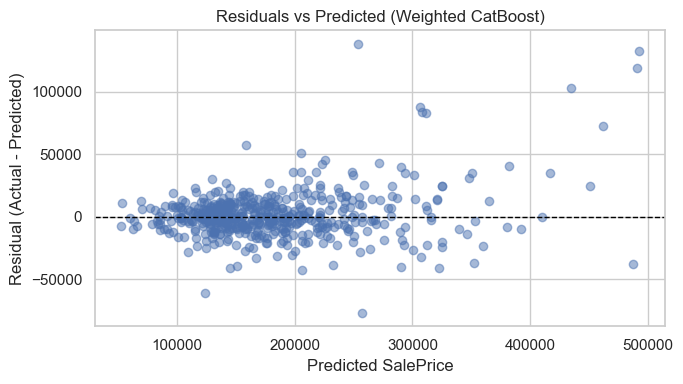

In [49]:
# 0) Restore clean data objects (avoid collisions)
Ames = Ames_original.copy()
y_target = Ames['SalePrice'].astype(float)
X_df = X_fe.copy()          # your engineered features dataframe

# 1) sanity checks
print(type(X_df), X_df.shape)
print(type(y_target), y_target.shape, y_target.head())

# 2) split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_target, test_size=0.20, random_state=42
)

# 3) price-proportional sample weights (tamed)
w_train = (y_train / y_train.mean()).clip(0.25, 4.0)

# 4) model (same preprocessing as before)
cb_weighted = make_catboost_pipe(
    X_df,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=5,
    iterations=1500,
    colsample_bylevel=0.8,
    verbose=0
)

# NOTE: model was trained on log1p target, so fit with log1p(y)
cb_weighted.fit(X_train, np.log1p(y_train), reg__sample_weight=w_train)

# 5) evaluate + residual plot
from sklearn.metrics import mean_squared_error, r2_score
y_pred_test = np.expm1(cb_weighted.predict(X_test))
residuals = y_test - y_pred_test

rmse = float(np.sqrt(mean_squared_error(y_test, y_pred_test)))
r2   = float(r2_score(y_test, y_pred_test))
print(f"Weighted CatBoost → RMSE: {rmse:,.0f}, R²: {r2:.3f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Weighted CatBoost)")
plt.tight_layout()
plt.show()

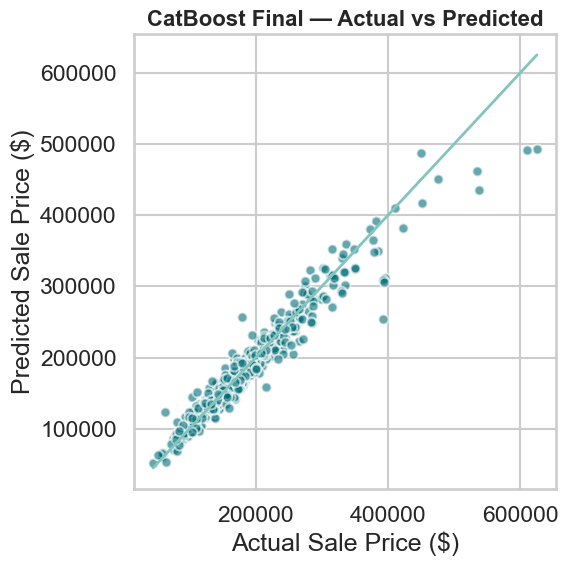

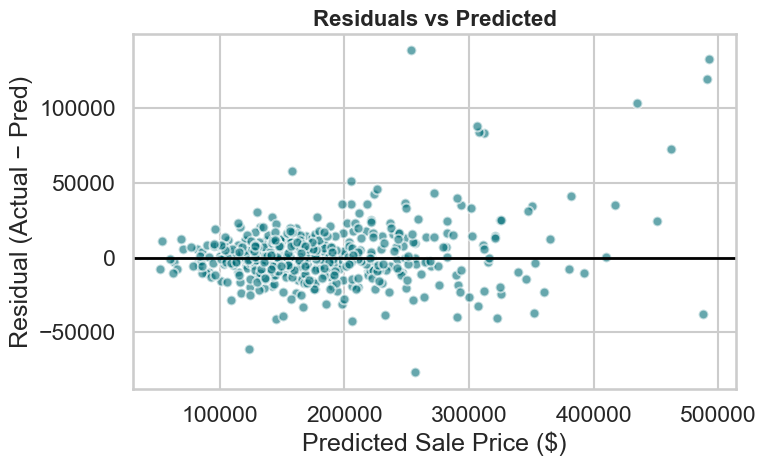

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Warwick slide theme colors (from your deck)
warwick_teal = "#006d77"
warwick_accent = "#83c5be"

sns.set_style("whitegrid")
sns.set_context("talk")

# --- 1. Parity Plot ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, color=warwick_teal, alpha=0.6, edgecolor="white", s=50)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color=warwick_accent, lw=2)
plt.title("CatBoost Final — Actual vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.tight_layout()
plt.show()

# --- 2. Residuals Plot ---
residuals = y_test - y_pred_test
plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, residuals, color=warwick_teal, alpha=0.6, edgecolor="white", s=50)
plt.axhline(0, color="black", lw=2)
plt.title("Residuals vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Predicted Sale Price ($)")
plt.ylabel("Residual (Actual − Pred)")
plt.tight_layout()
plt.show()

In [122]:
# === catboost_overnight_tuner_cpu.py ===

import json, time, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# =================== USER SWITCHES ===================
# Trials
N_TRIALS_STAGE1   = 400
N_TRIALS_STAGE2   = 100
CV_FOLDS          = 5
EARLY_STOP_ROUNDS = 200
RANDOM_STATE      = 42
HOLDOUT_TEST_SIZE = 0.20

# Progress / logging
SHOW_PROGRESS_BAR     = True
LOG_TRIAL_HEARTBEAT   = True     # "Trial N STARTED/COMPLETE" lines
HEARTBEAT_EVERY       = 1        # print every N trials

# Fail-fast pruning threshold (RMSE on raw $). Set to None to disable.
PRUNE_IF_RMSE_OVER    = 5e6

# Artifacts
ARTIFACT_DIR = Path("cb_tuning_artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)
LOG_FILE = ARTIFACT_DIR / "run.log"

def _log(line: str):
    print(line, flush=True)
    try:
        with open(LOG_FILE, "a") as f:
            f.write(line + "\n")
    except Exception:
        pass

# =================== UTILITIES ===================
def rmse(y_true, y_pred): 
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def has_make_catboost_pipe():
    return "make_catboost_pipe" in globals()

def build_pipe(X_sample, **params):
    """
    Use your make_catboost_pipe if available; else a plain CatBoostRegressor (CPU).
    """
    if has_make_catboost_pipe():
        params = {**params, "task_type": "CPU"}   # CPU only (macOS)
        return make_catboost_pipe(X_sample, **params)

    from catboost import CatBoostRegressor
    cat_params = dict(
        loss_function="RMSE",
        random_seed=RANDOM_STATE,
        verbose=False,                # keep CatBoost quiet (we log at trial-level)
        allow_writing_files=False,
        task_type="CPU",
    )
    cat_params.update(params)
    return CatBoostRegressor(**cat_params)

# ---------- Pipeline-safe eval_set routing + cat_features ----------
from pandas.api.types import is_object_dtype, is_categorical_dtype

def _fitparams_for_model(model, X_tr, y_tr, X_va, y_va, es_rounds):
    """
    Returns (fit_kwargs, Xtr_last, Xva_last).
    - Bare CatBoost:
        eval_set=(X_va, log1p(y_va)), early_stopping_rounds, and cat_features (if dtypes object/categorical)
    - Pipeline:
        Fit pre-steps on train, transform val; pass last_step__eval_set=(Xt_va, log1p(y_va))
        Only pass last_step__cat_features if Xt_tr is a DataFrame with object/categorical dtypes.
    """
    try:
        from sklearn.pipeline import Pipeline
        is_pipeline = isinstance(model, Pipeline)
    except Exception:
        is_pipeline = False

    if not is_pipeline:
        cat_idx = []
        if isinstance(X_tr, pd.DataFrame):
            cat_idx = [i for i, dt in enumerate(X_tr.dtypes)
                       if is_object_dtype(dt) or is_categorical_dtype(dt)]
        fit_kwargs = {
            "eval_set": (X_va, np.log1p(y_va)),
            "early_stopping_rounds": es_rounds,
            "verbose": False,   # IMPORTANT: do not also pass logging_level
        }
        if cat_idx:
            fit_kwargs["cat_features"] = cat_idx
        return fit_kwargs, X_tr, X_va

    # Pipeline case
    steps = model.steps
    pre_steps = steps[:-1]
    last_name, _ = steps[-1]

    Xt_tr, Xt_va = X_tr, X_va
    for name, step in pre_steps:
        if hasattr(step, "fit_transform"):
            try:
                Xt_tr = step.fit_transform(Xt_tr, np.log1p(y_tr))
            except TypeError:
                Xt_tr = step.fit_transform(Xt_tr)
        else:
            try:
                step.fit(Xt_tr, np.log1p(y_tr))
            except TypeError:
                step.fit(Xt_tr)
            Xt_tr = step.transform(Xt_tr)
        Xt_va = step.transform(Xt_va)

    cat_arg = {}
    if isinstance(Xt_tr, pd.DataFrame):
        cat_idx = [i for i, dt in enumerate(Xt_tr.dtypes)
                   if is_object_dtype(dt) or is_categorical_dtype(dt)]
        if cat_idx:
            cat_arg = {f"{last_name}__cat_features": cat_idx}

    fit_kwargs = {
        f"{last_name}__eval_set": (Xt_va, np.log1p(y_va)),
        f"{last_name}__early_stopping_rounds": es_rounds,
        f"{last_name}__verbose": False,
        **cat_arg
    }
    return fit_kwargs, Xt_tr, Xt_va

# ---------- CV (train in log space; score on raw) ----------
def cv_score_params(X, y, params, folds=CV_FOLDS, es_rounds=EARLY_STOP_ROUNDS):
    # ensure clean indices and alignment
    if not isinstance(X.index, pd.RangeIndex):
        X = X.reset_index(drop=True)
    if not isinstance(y.index, pd.RangeIndex):
        y = y.reset_index(drop=True)
    assert len(X) == len(y), f"Length mismatch: X={len(X)} vs y={len(y)}"

    kf = KFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    rmses = []

    for tr_idx, va_idx in kf.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        model = build_pipe(X_tr,
            iterations=params.get("iterations", 3000),
            learning_rate=params.get("learning_rate", 0.05),
            depth=params.get("depth", 6),
            l2_leaf_reg=params.get("l2_leaf_reg", 3.0),
            subsample=params.get("subsample", 1.0),
            colsample_bylevel=params.get("colsample_bylevel", 1.0),
            bagging_temperature=params.get("bagging_temperature", 0.0),
            random_strength=params.get("random_strength", 1.0),
            min_data_in_leaf=params.get("min_data_in_leaf", 1),
            loss_function="RMSE",
            random_state=RANDOM_STATE,
            verbose=0
        )

        fit_kwargs, _, _ = _fitparams_for_model(model, X_tr, y_tr, X_va, y_va, es_rounds)

        # Train in log-space
        model.fit(X_tr, np.log1p(y_tr), **fit_kwargs)

        # Predict in log-space -> invert
        y_va_pred_log = model.predict(X_va)
        y_va_pred = np.expm1(y_va_pred_log)

        rmses.append(rmse(y_va, y_va_pred))

    return float(np.mean(rmses)), float(np.std(rmses))

# ---------- Param spaces ----------
def make_param_neighbors(best):
    """Build a narrowed Stage 2 search space around Stage 1 best."""
    def around(val, frac_low=0.6, frac_high=1.5, low=None, high=None, integer=False):
        lo = max(low if low is not None else -np.inf, val * frac_low)
        hi = min(high if high is not None else  np.inf, val * frac_high)
        if integer:
            lo = max(1, int(round(lo)))
            hi = int(round(hi))
        return lo, hi

    nb = {}
    d  = int(best.get("depth", 6))
    it = int(best.get("iterations", 2500))
    lr = float(best.get("learning_rate", 0.05))
    l2 = float(best.get("l2_leaf_reg", 3.0))
    sub= float(best.get("subsample", 0.9))
    col= float(best.get("colsample_bylevel", 0.8))
    bt = float(best.get("bagging_temperature", 0.5))
    rs = float(best.get("random_strength", 1.0))
    md = int(best.get("min_data_in_leaf", 1))

    nb["depth"]               = around(d, 0.8, 1.2, low=4,   high=10, integer=True)
    nb["iterations"]          = around(it, 0.7, 1.3, low=1200, high=8000, integer=True)
    nb["learning_rate"]       = (max(1e-3, lr/1.8), min(0.12, lr*1.8))
    nb["l2_leaf_reg"]         = (max(1e-3, l2/3),   min(50.0, l2*3))
    nb["subsample"]           = (max(0.7, sub/1.3), min(1.0, sub*1.15))
    nb["colsample_bylevel"]   = (max(0.6, col/1.25),min(1.0, col*1.2))
    nb["bagging_temperature"] = (0.0, max(3.0, bt*2))
    nb["random_strength"]     = (0.0, max(2.0, rs*2))
    nb["min_data_in_leaf"]    = around(max(1, md), 0.6, 1.8, low=1, high=512, integer=True)
    return nb

def suggest_params_optuna(trial, stage2_space=None):
    if stage2_space is None:
        # Stage 1 (broad but sane)
        depth  = trial.suggest_int("depth", 4, 9)
        iterations = trial.suggest_int("iterations", 1200, 7000)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.12, log=True)
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 0.05, 50.0, log=True)
        subsample = trial.suggest_float("subsample", 0.7, 1.0)
        colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.6, 1.0)
        bagging_temperature = trial.suggest_float("bagging_temperature", 0.0, 3.0)
        random_strength = trial.suggest_float("random_strength", 0.0, 2.0)
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 256)
    else:
        d_lo, d_hi = stage2_space["depth"]
        it_lo, it_hi = stage2_space["iterations"]
        lr_lo, lr_hi = stage2_space["learning_rate"]
        l2_lo, l2_hi = stage2_space["l2_leaf_reg"]
        sub_lo, sub_hi = stage2_space["subsample"]
        col_lo, col_hi = stage2_space["colsample_bylevel"]
        bt_lo, bt_hi = stage2_space["bagging_temperature"]
        rs_lo, rs_hi = stage2_space["random_strength"]
        md_lo, md_hi = stage2_space["min_data_in_leaf"]

        depth  = trial.suggest_int("depth", d_lo, d_hi)
        iterations = trial.suggest_int("iterations", it_lo, it_hi)
        learning_rate = trial.suggest_float("learning_rate", lr_lo, lr_hi, log=True)
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", l2_lo, l2_hi, log=True)
        subsample = trial.suggest_float("subsample", sub_lo, sub_hi)
        colsample_bylevel = trial.suggest_float("colsample_bylevel", col_lo, col_hi)
        bagging_temperature = trial.suggest_float("bagging_temperature", bt_lo, bt_hi)
        random_strength = trial.suggest_float("random_strength", rs_lo, rs_hi)
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", md_lo, md_hi)

    return dict(
        depth=depth,
        iterations=iterations,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        colsample_bylevel=colsample_bylevel,
        bagging_temperature=bagging_temperature,
        random_strength=random_strength,
        min_data_in_leaf=min_data_in_leaf,
        loss_function="RMSE",
        random_state=RANDOM_STATE,
        verbose=0
    )

# ---------- Trial heartbeat ----------
def _trial_logger(study, tr):
    """
    Works both from objective (Trial) and as callback (FrozenTrial).
    """
    try:
        from optuna.trial import TrialState
    except Exception:
        TrialState = None

    every = max(1, HEARTBEAT_EVERY)

    # Called from objective: Trial (no .state) -> START ping
    if not hasattr(tr, "state"):
        if (tr.number % every) == 0:
            _log(f"[Optuna] Trial {tr.number} STARTED")
        return

    # Called as callback: FrozenTrial (has .state) -> END ping
    if (tr.number % every) != 0:
        return

    state = getattr(tr, "state", None)
    state_name = getattr(state, "name", str(state))

    best_val = getattr(study, "best_value", None)
    best_txt = f"{best_val:.5f}" if isinstance(best_val, (int, float)) else "n/a"

    if tr.value is not None:
        val_txt = f"{tr.value:.5f}"
    elif TrialState is not None and state == TrialState.PRUNED:
        inter = getattr(tr, "intermediate_values", {}) or {}
        val_txt = f"PRUNED:{min(inter.values()):.5f}" if inter else "PRUNED"
    else:
        val_txt = state_name

    _log(f"[Optuna] Trial {tr.number} {state_name} | value={val_txt} | best={best_txt}")

# ---------- Optuna driver ----------
def run_optuna_tuning(X, y):
    try:
        import optuna
        from optuna.pruners import MedianPruner
        from optuna.samplers import TPESampler
        from optuna.exceptions import TrialPruned
    except Exception as e:
        return None, f"Optuna not available: {e}"

    # Shared storage (so you keep history on disk)
    storage = f"sqlite:///{ARTIFACT_DIR / 'optuna_cb.sqlite'}"

    # Stage 1 study
    study1 = optuna.create_study(
        direction="minimize",
        study_name=f"cb_ames_stage1_{int(time.time())}",
        storage=storage,
        load_if_exists=False,
        sampler=TPESampler(
            seed=RANDOM_STATE,
            multivariate=True,
            group=True,                       # allowed only when multivariate=True
            warn_independent_sampling=False,
        ),
        pruner=MedianPruner(n_startup_trials=20, n_warmup_steps=0),
    )

    _log(f"[Stage 1] Starting {N_TRIALS_STAGE1} trials…")

    def objective_stage1(trial):
        if LOG_TRIAL_HEARTBEAT: _trial_logger(study1, trial)
        params = suggest_params_optuna(trial, stage2_space=None)
        mean_rmse, std_rmse = cv_score_params(X, y, params)

        # optional fail-fast
        if PRUNE_IF_RMSE_OVER and mean_rmse > PRUNE_IF_RMSE_OVER:
            raise optuna.TrialPruned(f"RMSE too large: {mean_rmse:,.0f}")

        trial.set_user_attr("std_rmse", std_rmse)
        # rolling save
        try:
            if study1.best_trial is None or mean_rmse <= study1.best_value + 1e-12:
                with open(ARTIFACT_DIR / "best_so_far_stage1.json", "w") as f:
                    json.dump({**params, "mean_rmse": mean_rmse, "std_rmse": std_rmse}, f, indent=2)
        except Exception:
            pass
        return mean_rmse

    study1.optimize(
        objective_stage1,
        n_trials=N_TRIALS_STAGE1,
        show_progress_bar=SHOW_PROGRESS_BAR,
        callbacks=[_trial_logger] if LOG_TRIAL_HEARTBEAT else None,
    )
    best1 = study1.best_params.copy()
    with open(ARTIFACT_DIR / "optuna_stage1_best.json", "w") as f:
        json.dump(best1, f, indent=2)

    # Stage 2: new study with narrowed space
    study2 = optuna.create_study(
        direction="minimize",
        study_name=f"cb_ames_stage2_{int(time.time())}",
        storage=storage,
        load_if_exists=False,
        sampler=TPESampler(
            seed=RANDOM_STATE,
            multivariate=True,
            group=True,
            warn_independent_sampling=False,
        ),
        pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=0),
    )

    _log(f"[Stage 2] Starting {N_TRIALS_STAGE2} trials around Stage 1 best…")
    neigh = make_param_neighbors(best1)

    def objective_stage2(trial):
        if LOG_TRIAL_HEARTBEAT: _trial_logger(study2, trial)
        params = suggest_params_optuna(trial, stage2_space=neigh)
        mean_rmse, std_rmse = cv_score_params(X, y, params)

        if PRUNE_IF_RMSE_OVER and mean_rmse > PRUNE_IF_RMSE_OVER:
            raise optuna.TrialPruned(f"RMSE too large: {mean_rmse:,.0f}")

        trial.set_user_attr("std_rmse", std_rmse)
        try:
            if study2.best_trial is None or mean_rmse <= study2.best_value + 1e-12:
                with open(ARTIFACT_DIR / "best_so_far_stage2.json", "w") as f:
                    json.dump({**params, "mean_rmse": mean_rmse, "std_rmse": std_rmse}, f, indent=2)
        except Exception:
            pass
        return mean_rmse

    study2.optimize(
        objective_stage2,
        n_trials=N_TRIALS_STAGE2,
        show_progress_bar=SHOW_PROGRESS_BAR,
        callbacks=[_trial_logger] if LOG_TRIAL_HEARTBEAT else None,
    )

    # Persist
    try:
        study2.trials_dataframe().to_csv(ARTIFACT_DIR / "optuna_trials_stage2.csv", index=False)
        study1.trials_dataframe().to_csv(ARTIFACT_DIR / "optuna_trials_stage1.csv", index=False)
    except Exception:
        pass
    joblib.dump(study1, ARTIFACT_DIR / "optuna_study_stage1.pkl")
    joblib.dump(study2, ARTIFACT_DIR / "optuna_study_stage2.pkl")

    # Choose best of stage2; if none better, fallback to stage1
    best_study = study2 if study2.best_value <= study1.best_value else study1
    return best_study, None

# ---------- Final refit & report ----------
def final_refit_and_report(X, y, params, test_size=HOLDOUT_TEST_SIZE):
    # clean indices
    if not isinstance(X.index, pd.RangeIndex): X = X.reset_index(drop=True)
    if not isinstance(y.index, pd.RangeIndex): y = y.reset_index(drop=True)
    assert len(X) == len(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE
    )

    model = build_pipe(X_train, **params)

    fit_kwargs, _, _ = _fitparams_for_model(
        model, X_train, y_train, X_test, y_test, EARLY_STOP_ROUNDS
    )
    # Train in log-space
    model.fit(X_train, np.log1p(y_train), **fit_kwargs)

    # Predict & invert
    y_pred_tr = np.expm1(model.predict(X_train))
    y_pred_te = np.expm1(model.predict(X_test))

    scores = {
        "train_rmse": rmse(y_train, y_pred_tr),
        "train_r2": float(r2_score(y_train, y_pred_tr)),
        "test_rmse": rmse(y_test, y_pred_te),
        "test_r2": float(r2_score(y_test, y_pred_te)),
    }

    joblib.dump(model, ARTIFACT_DIR / "cb_best.pkl")
    with open(ARTIFACT_DIR / "cb_best_params.json", "w") as f:
        json.dump(params, f, indent=2)
    with open(ARTIFACT_DIR / "cb_best_scores.json", "w") as f:
        json.dump(scores, f, indent=2)
    with open(ARTIFACT_DIR / "cb_best_scorecard.txt", "w") as f:
        f.write("CatBoost Best Model (tuned) Performance\n")
        f.write(f"Train RMSE: {scores['train_rmse']:,.0f}, R²: {scores['train_r2']:.3f}\n")
        f.write(f" Test RMSE: {scores['test_rmse']:,.0f}, R²: {scores['test_r2']:.3f}\n")
        f.write("\nBest Parameters:\n")
        for k, v in params.items():
            f.write(f"  {k}: {v}\n")
    return scores

# ---------- Target resolver & sanity helpers ----------
def _ensure_raw_target(y_series: pd.Series) -> pd.Series:
    """
    If y looks log-transformed (Ames typical logs ~10-14), convert back via expm1.
    Otherwise return as-is.
    """
    y = pd.Series(y_series).astype(float)
    looks_log = (y.min() >= 0) and (y.max() < 25) and (y.median() < 16)
    if looks_log:
        _log("Detected log-transformed target; converting back to raw via expm1.")
        return pd.Series(np.expm1(y.values), index=y.index, name=y.name or "target")
    return y

def quick_sanity_cv(X, y):
    """3-fold quick check on your original baseline params."""
    base = dict(
        depth=6, learning_rate=0.05, l2_leaf_reg=5, iterations=1500,
        subsample=1.0, colsample_bylevel=0.8,
        bagging_temperature=0.0, random_strength=1.0, min_data_in_leaf=1,
        loss_function="RMSE", random_state=RANDOM_STATE, verbose=0
    )
    m, s = cv_score_params(X, y, base, folds=3, es_rounds=100)
    _log(f"[Sanity] Baseline 3-fold CV RMSE: {m:,.0f} ± {s:,.0f}")

# =================== MAIN ===================
if __name__ == "__main__":
    _log("Starting CatBoost tuning (CPU) with progress heartbeat…")

    # 1) Features
    if "X_fe" not in globals():
        raise ValueError("X_fe not found. Define your engineered feature DataFrame as X_fe.")
    X_data = X_fe.copy() if isinstance(X_fe, pd.DataFrame) else pd.DataFrame(X_fe)

    # 2) Resolve target robustly
    def _is_array_like(v):
        try:
            import numpy as _np
            return hasattr(v, "__len__") and not _np.isscalar(v)
        except Exception:
            return hasattr(v, "__len__")
    def _to_series(v, name="target"):
        if isinstance(v, pd.Series): return v.copy()
        if isinstance(v, pd.DataFrame): return v.iloc[:, 0].copy()
        if _is_array_like(v): return pd.Series(v, name=name)
        return None

    y_candidates = []
    for nm in ["y", "y_fe", "y_series", "target", "y_data_full", "y_full"]:
        if nm in globals():
            s = _to_series(globals()[nm], name="target")
            if s is not None and len(s) == len(X_data): y_candidates.append(("global:"+nm, s))
    if not y_candidates and "Ames" in globals():
        try:
            if isinstance(Ames, pd.DataFrame) and "SalePrice" in Ames.columns:
                s = Ames["SalePrice"]
                s = _to_series(s, name="SalePrice")
                if s is not None and len(s) == len(X_data): y_candidates.append(("Ames:SalePrice", s))
        except Exception: pass
    if not y_candidates:
        raise ValueError("Could not resolve target y with matching length. Set y = Ames['SalePrice'].")

    _, y_data = y_candidates[0]

    # 3) Align, de-NA, ensure RAW target scale
    if isinstance(y_data, pd.DataFrame): y_data = y_data.iloc[:, 0]
    elif not isinstance(y_data, pd.Series): y_data = pd.Series(y_data, name="target")
    mask = ~pd.Series(y_data).isna()
    X_data, y_data = X_data.loc[mask.values], pd.Series(y_data).loc[mask.values]
    X_data = X_data.reset_index(drop=True)
    y_data = y_data.reset_index(drop=True)
    assert len(X_data) == len(y_data) and len(X_data) > 10
    y_data = _ensure_raw_target(y_data)

    # 4) Quick sanity check (fast 3-fold on baseline)
    quick_sanity_cv(X_data, y_data)

    # 5) Tune
    best_study, err = run_optuna_tuning(X_data, y_data)
    if best_study is None:study.optimize
        raise RuntimeError(err)

    best_params = best_study.best_params.copy()
    best_params.update(dict(loss_function="RMSE", random_state=RANDOM_STATE, verbose=0))
    with open(ARTIFACT_DIR / "optuna_best.json", "w") as f:
        json.dump(best_params, f, indent=2)

    # 6) Final refit + report (holdout)
    scores = final_refit_and_report(X_data, y_data, best_params)
    _log("\n=== Tuned CatBoost Model Performance (Holdout) ===")
    _log(f"Train RMSE: {scores['train_rmse']:,.0f}, R²: {scores['train_r2']:.3f}")
    _log(f" Test RMSE: {scores['test_rmse']:,.0f}, R²: {scores['test_r2']:.3f}")
    _log(f"\nArtifacts saved to: {ARTIFACT_DIR.resolve()}")

Starting CatBoost tuning (CPU) with progress heartbeat…
[Sanity] Baseline 3-fold CV RMSE: 19,500 ± 2,375


[I 2025-09-11 21:53:25,182] A new study created in RDB with name: cb_ames_stage1_1757642005


[Stage 1] Starting 400 trials…


  0%|          | 0/400 [00:00<?, ?it/s]

[Optuna] Trial 0 STARTED
[I 2025-09-11 21:53:35,500] Trial 0 finished with value: 19804.70401824879 and parameters: {'depth': 6, 'iterations': 6715, 'learning_rate': 0.061652988679205906, 'l2_leaf_reg': 3.125686787260873, 'subsample': 0.7468055921327309, 'colsample_bylevel': 0.662397808134481, 'bagging_temperature': 0.17425083650459838, 'random_strength': 1.7323522915498704, 'min_data_in_leaf': 154}. Best is trial 0 with value: 19804.70401824879.
[Optuna] Trial 0 COMPLETE | value=19804.70402 | best=19804.70402
[Optuna] Trial 1 STARTED
[I 2025-09-11 21:53:58,515] Trial 1 finished with value: 20337.398109747992 and parameters: {'depth': 8, 'iterations': 1319, 'learning_rate': 0.11135469245723131, 'l2_leaf_reg': 15.71440445420054, 'subsample': 0.7637017332034828, 'colsample_bylevel': 0.6727299868828402, 'bagging_temperature': 0.5502135295603015, 'random_strength': 0.6084844859190754, 'min_data_in_leaf': 135}. Best is trial 0 with value: 19804.70401824879.
[Optuna] Trial 1 COMPLETE | value

[I 2025-09-11 23:48:14,357] A new study created in RDB with name: cb_ames_stage2_1757648894


[Stage 2] Starting 100 trials around Stage 1 best…


  0%|          | 0/100 [00:00<?, ?it/s]

[Optuna] Trial 0 STARTED
[I 2025-09-11 23:48:25,956] Trial 0 finished with value: 19617.246249520937 and parameters: {'depth': 5, 'iterations': 7845, 'learning_rate': 0.03395291975330049, 'l2_leaf_reg': 6.704745644531266, 'subsample': 0.7383023873695047, 'colsample_bylevel': 0.6339934100522924, 'bagging_temperature': 0.17425083650459838, 'random_strength': 1.7323522915498704, 'min_data_in_leaf': 217}. Best is trial 0 with value: 19617.246249520937.
[Optuna] Trial 0 COMPLETE | value=19617.24625 | best=19617.24625
[Optuna] Trial 1 STARTED
[I 2025-09-11 23:48:45,135] Trial 1 finished with value: 19691.7596239689 and parameters: {'depth': 6, 'iterations': 4918, 'learning_rate': 0.04491008819081262, 'l2_leaf_reg': 11.206476560510039, 'subsample': 0.7521289946369979, 'colsample_bylevel': 0.6396222293878945, 'bagging_temperature': 0.5502135295603015, 'random_strength': 0.6084844859190754, 'min_data_in_leaf': 201}. Best is trial 0 with value: 19617.246249520937.
[Optuna] Trial 1 COMPLETE | val

In [124]:
best_params

{'depth': 5,
 'iterations': 6935,
 'learning_rate': 0.025848406661638512,
 'l2_leaf_reg': 5.398065963881286,
 'subsample': 0.822172860442869,
 'colsample_bylevel': 0.6815951076306457,
 'bagging_temperature': 0.47001460667988826,
 'random_strength': 0.2988430979118698,
 'min_data_in_leaf': 164,
 'loss_function': 'RMSE',
 'random_state': 42,
 'verbose': 0}

In [125]:
# === finalize_and_save.py (drop-in cell) ===
import json, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
from pandas.api.types import is_object_dtype, is_categorical_dtype

ARTIFACT_DIR = Path("cb_tuning_artifacts")
OUT_MODEL    = ARTIFACT_DIR / "cb_final_all.pkl"
OUT_SCORE    = ARTIFACT_DIR / "cb_final_all_scorecard.txt"
OUT_IMP_CSV  = ARTIFACT_DIR / "cb_final_perm_importances.csv"

RANDOM_STATE = 42
CV_FOLDS     = 3

# ---------- tiny utils ----------
def _log(s): print(s, flush=True)
def rmse(y_true, y_pred): return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def _ensure_raw_target(y_series: pd.Series) -> pd.Series:
    """If y looks log1p-transformed (Ames logs ~10-14), convert back."""
    y = pd.Series(y_series).astype(float)
    looks_log = (y.min() >= 0) and (y.max() < 25) and (y.median() < 16)
    return pd.Series(np.expm1(y), index=y.index, name=y.name) if looks_log else y

def _cat_feature_indices(X: pd.DataFrame):
    if not isinstance(X, pd.DataFrame): return []
    return [i for i, dt in enumerate(X.dtypes)
            if is_object_dtype(dt) or is_categorical_dtype(dt)]

def has_make_catboost_pipe():
    return "make_catboost_pipe" in globals()

def build_pipe(X_sample, **params):
    """Use your make_catboost_pipe if available; else plain CatBoostRegressor."""
    if has_make_catboost_pipe():
        params = {**params, "task_type": "CPU"}
        return make_catboost_pipe(X_sample, **params)
    from catboost import CatBoostRegressor
    cat_params = dict(
        loss_function="RMSE",
        random_seed=RANDOM_STATE,
        verbose=False,
        allow_writing_files=False,
        task_type="CPU",
    )
    cat_params.update(params)
    return CatBoostRegressor(**cat_params)

# ---------- resolve X/y ----------
if "X_fe" not in globals():
    raise ValueError("X_fe not found. Define your engineered feature DataFrame as X_fe.")
X_all = X_fe.copy() if isinstance(X_fe, pd.DataFrame) else pd.DataFrame(X_fe)

def _to_series(v, name="target"):
    if isinstance(v, pd.Series): return v
    if isinstance(v, pd.DataFrame): return v.iloc[:, 0]
    try:
        import numpy as _np
        if hasattr(v, "__len__") and not _np.isscalar(v):
            return pd.Series(v, name=name)
    except Exception:
        pass
    return None

y_candidates = []
for nm in ["y", "y_fe", "y_series", "target", "y_data_full", "y_full"]:
    if nm in globals():
        s = _to_series(globals()[nm], "target")
        if s is not None and len(s) == len(X_all): y_candidates.append(s)
if not y_candidates and "Ames" in globals() and isinstance(Ames, pd.DataFrame) and "SalePrice" in Ames.columns:
    s = _to_series(Ames["SalePrice"], "SalePrice")
    if s is not None and len(s) == len(X_all): y_candidates.append(s)
if not y_candidates:
    raise ValueError("Could not resolve target y with matching length. Set y = Ames['SalePrice'].")

y_all = y_candidates[0].copy()
mask = ~pd.Series(y_all).isna()
X_all = X_all.loc[mask.values].reset_index(drop=True)
y_all = pd.Series(y_all).loc[mask.values].reset_index(drop=True)
y_all = _ensure_raw_target(y_all)

# ---------- load best params / best iteration ----------
best_params_path = ARTIFACT_DIR / "cb_best_params.json"
if not best_params_path.exists():
    # fallback to optuna_best.json if present
    best_params_path = ARTIFACT_DIR / "optuna_best.json"
best_params = json.load(open(best_params_path))

# Try to read best_iteration from the tuned model
best_iter = None
try:
    tuned_model = joblib.load(ARTIFACT_DIR / "cb_best.pkl")
    get_best = getattr(tuned_model, "get_best_iteration", None)
    if callable(get_best):
        bi = get_best()
        if isinstance(bi, (int, np.integer)) and bi > 0:
            best_iter = int(bi)
            _log(f"Using best_iteration from tuned model: {best_iter}")
except Exception:
    pass

# If we didn't find it, keep iterations from best_params
if best_iter is not None:
    best_params["iterations"] = best_iter

# Ensure required CatBoost knobs
best_params.update(dict(loss_function="RMSE", random_state=RANDOM_STATE, verbose=0))

# ---------- final REFIT on ALL data (log-space training) ----------
model = build_pipe(X_all, **best_params)

fit_kwargs = {}
# Bare CatBoost: pass cat_features indices if raw categoricals remain
try:
    from catboost import CatBoostRegressor
    if isinstance(model, CatBoostRegressor):
        cat_idx = _cat_feature_indices(X_all)
        if cat_idx:
            fit_kwargs["cat_features"] = cat_idx
except Exception:
    pass

_log("Refitting final model on ALL data (log-space)…")
model.fit(X_all, np.log1p(y_all), **fit_kwargs)

joblib.dump(model, OUT_MODEL)

# ---------- quick 3-fold CV sanity (on final params) ----------
kf = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
rmses = []
for tr_idx, va_idx in kf.split(X_all):
    X_tr, X_va = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    y_tr, y_va = y_all.iloc[tr_idx], y_all.iloc[va_idx]
    m = build_pipe(X_tr, **best_params)
    kw = {}
    try:
        from catboost import CatBoostRegressor
        if isinstance(m, CatBoostRegressor):
            cat_idx = _cat_feature_indices(X_tr)
            if cat_idx: kw["cat_features"] = cat_idx
    except Exception:
        pass
    m.fit(X_tr, np.log1p(y_tr), **kw)
    y_pred = np.expm1(m.predict(X_va))
    rmses.append(rmse(y_va, y_pred))

cv_mean, cv_std = float(np.mean(rmses)), float(np.std(rmses))
_log(f"[Finalize] 3-fold CV RMSE: {cv_mean:,.0f} ± {cv_std:,.0f}")

# ---------- permutation importances (fast subsample) ----------
# We wrap predict() to output raw-scale predictions for the scorer.
# --- replace the previous LogToRawPredictor + PI call with this ---

# No-op estimator that adapts the already-fitted CatBoost model to raw-scale predictions
class LogToRawEstimator:
    def __init__(self, fitted_model):
        self.model = fitted_model  # already fitted
    def fit(self, X, y=None):
        # permutation_importance requires a fit method; we don't refit
        return self
    def predict(self, X):
        import numpy as _np
        return _np.expm1(self.model.predict(X))

# Use a built-in scorer to keep things simple
from sklearn.metrics import get_scorer
neg_rmse_scorer = get_scorer("neg_root_mean_squared_error")

_log("Computing permutation importances on a small subsample…")
wrapped = LogToRawEstimator(model)
pi = permutation_importance(
    wrapped,
    X_imp, y_imp,
    scoring=neg_rmse_scorer,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=1
)
imp_df = pd.DataFrame({
    "feature": list(X_all.columns),
    "importance_mean": pi.importances_mean,
    "importance_std": pi.importances_std
}).sort_values("importance_mean", ascending=False)
imp_df.to_csv(OUT_IMP_CSV, index=False)

# ---------- write scorecard ----------
with open(OUT_SCORE, "w") as f:
    f.write("CatBoost Final Model (ALL data) — Scorecard\n")
    f.write(f"Params file: {best_params_path.name}\n")
    if best_iter is not None:
        f.write(f"best_iteration used: {best_iter}\n")
    f.write(f"3-fold CV RMSE: {cv_mean:,.0f} ± {cv_std:,.0f}\n")
    f.write("\nTop 15 permutation importances (mean):\n")
    for _, r in imp_df.head(15).iterrows():
        f.write(f"  {r['feature']}: {r['importance_mean']:.3f} ± {r['importance_std']:.3f}\n")

_log("\n=== Finalization Complete ===")
_log(f"Saved model: {OUT_MODEL}")
_log(f"Scorecard:   {OUT_SCORE}")
_log(f"Importances:  {OUT_IMP_CSV}")

Refitting final model on ALL data (log-space)…
[Finalize] 3-fold CV RMSE: 19,341 ± 2,819
Computing permutation importances on a small subsample…

=== Finalization Complete ===
Saved model: cb_tuning_artifacts/cb_final_all.pkl
Scorecard:   cb_tuning_artifacts/cb_final_all_scorecard.txt
Importances:  cb_tuning_artifacts/cb_final_perm_importances.csv


In [ ]:
# ================================
# Next-Round CatBoost Experimenter (safe, with logging)
# ================================
import os, time, json, math, warnings
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.trial import TrialState

from catboost import CatBoostRegressor

# ---------- Config ----------
ARTIFACT_DIR = Path("cb_round2_artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

STORAGE = f"sqlite:///{ARTIFACT_DIR / 'optuna_cb_round2.sqlite'}"
STUDY_NAME = f"cb_round2_{int(time.time())}"

RANDOM_STATE = 42
N_FOLDS = 3
N_TRIALS = 240        # overnight-friendly
SHAPLETS = 800        # sample size for permutation importance
HEARTBEAT_EVERY = 1   # print a line every N trials

# ---------- Utilities ----------
def _log(msg):
    print(msg, flush=True)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def _resolve_Xy():
    if "X_fe" not in globals():
        raise ValueError("X_fe not found. Provide your feature DataFrame in variable `X_fe`.")
    X = X_fe.copy() if isinstance(X_fe, pd.DataFrame) else pd.DataFrame(X_fe)

    def _to_series(v, name="target"):
        if isinstance(v, pd.Series): return v
        if isinstance(v, pd.DataFrame): return v.iloc[:, 0]
        try:
            if hasattr(v, "__len__"):
                return pd.Series(v, name=name)
        except Exception:
            pass
        return None

    y_series = None
    for nm in ["y", "y_fe", "y_series", "target", "y_data_full", "y_full"]:
        if nm in globals():
            cand = _to_series(globals()[nm], "target")
            if cand is not None and len(cand) == len(X):
                y_series = cand
                break
    if y_series is None:
        raise ValueError("Could not resolve target y aligned with X_fe.")

    # Ensure raw (not log) target for scoring
    y_series = pd.Series(y_series).astype(float)
    if (y_series.min() >= 0) and (y_series.max() < 25) and (y_series.median() < 16):
        _log("[Info] Detected log-like target; converting back with expm1 for scoring.")
        y_series = pd.Series(np.expm1(y_series.values), index=y_series.index)

    mask = ~y_series.isna()
    X, y_series = X.loc[mask.values].reset_index(drop=True), y_series.loc[mask.values].reset_index(drop=True)
    return X, y_series

# --- CatBoost-native categorical prep ---
from pandas.api.types import (
    is_object_dtype, is_categorical_dtype, is_integer_dtype, is_float_dtype
)

def _is_numeric_like(obj_col: pd.Series, tol: float = 0.99) -> bool:
    if is_integer_dtype(obj_col) or is_float_dtype(obj_col):
        return True
    parsed = pd.to_numeric(obj_col, errors="coerce")
    return (1.0 - parsed.isna().mean()) >= tol

def sanitize_for_catboost(df: pd.DataFrame, sentinel="__NA__"):
    """
    Returns (df_fixed, cat_idx) for CatBoost:
      - 'true' categoricals -> string, NaN -> sentinel
      - numeric or numeric-like categoricals (e.g., MSSubClass) -> float32
    """
    out = df.copy()
    cat_cols, num_cols = [], []
    for c in out.columns:
        dt = out[c].dtype
        if is_object_dtype(dt) or is_categorical_dtype(dt):
            if _is_numeric_like(out[c].astype("object")):
                num_cols.append(c)
            else:
                cat_cols.append(c)
        else:
            num_cols.append(c)

    for c in num_cols:
        out[c] = pd.to_numeric(out[c], errors="coerce").astype("float32")
    for c in cat_cols:
        col = out[c].astype("object")
        col = col.where(col.notna(), sentinel)
        out[c] = col.astype(str)

    cat_idx = [out.columns.get_loc(c) for c in cat_cols]
    return out, cat_idx

# --- Feature engineering blocks ---
def fe_base(X: pd.DataFrame) -> pd.DataFrame:
    """Safe base FE: keeps original cols, adds common gains — DOES NOT overwrite TotalBaths."""
    Z = X.copy()

    def add(col, series):
        try:
            Z[col] = series
        except Exception:
            pass

    # Popular Ames transforms (guarded)
    if "GrLivArea" in Z: add("log_GrLivArea", np.log1p(pd.to_numeric(Z["GrLivArea"], errors="coerce")))
    if "LotArea"   in Z: add("log_LotArea",   np.log1p(pd.to_numeric(Z["LotArea"], errors="coerce")))
    if {"TotalBsmtSF","1stFlrSF","2ndFlrSF"}.issubset(Z.columns):
        add("TotalSF", pd.to_numeric(Z["TotalBsmtSF"], errors="coerce")
                        + pd.to_numeric(Z["1stFlrSF"], errors="coerce")
                        + pd.to_numeric(Z["2ndFlrSF"], errors="coerce"))
    if "OverallQual" in Z and "TotalSF" in Z:
        add("TotalSF_x_Qual", pd.to_numeric(Z["TotalSF"], errors="coerce")
                              * pd.to_numeric(Z["OverallQual"], errors="coerce"))
    if "TotalSF" in Z and "LotArea" in Z:
        la = pd.to_numeric(Z["LotArea"], errors="coerce")
        add("TotalSF_div_LotArea", pd.to_numeric(Z["TotalSF"], errors="coerce") / (la.replace(0, np.nan)))

    # 👉 DON'T overwrite your tuned TotalBaths if it's already present
    if {"FullBath","HalfBath"}.issubset(Z.columns) and "TotalBaths" not in Z:
        add("TotalBaths",
            pd.to_numeric(Z["FullBath"], errors="coerce")
            + 0.5 * pd.to_numeric(Z["HalfBath"], errors="coerce")
        )

    if "YearBuilt" in Z and "YearRemodAdd" in Z:
        add("HouseAgeSinceRemod",
            pd.to_numeric(Z["YearRemodAdd"], errors="coerce") - pd.to_numeric(Z["YearBuilt"], errors="coerce"))

    return Z

def fe_extended(X: pd.DataFrame) -> pd.DataFrame:
    """Extra features that often help, more experimental."""
    Z = fe_base(X)
    if "OverallQual" in Z:
        oq = pd.to_numeric(Z["OverallQual"], errors="coerce")
        for c in ["GrLivArea","TotalBsmtSF","GarageArea","TotalSF"]:
            if c in Z:
                Z[f"{c}_x_Qual"] = pd.to_numeric(Z[c], errors="coerce") * oq
    if {"TotRmsAbvGrd","GrLivArea"}.issubset(Z.columns):
        gl = pd.to_numeric(Z["GrLivArea"], errors="coerce")
        Z["Rooms_per_1000SF"] = pd.to_numeric(Z["TotRmsAbvGrd"], errors="coerce") / (gl/1000.0).replace(0, np.nan)
    return Z

# --- Sampler space (CatBoost + FE toggles) ---
def suggest_params(trial: optuna.Trial):
    params = dict(
        depth=trial.suggest_int("depth", 4, 10),
        iterations=trial.suggest_int("iterations", 2000, 8000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-3, 20.0, log=True),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.4, 1.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 3.0),
        random_strength=trial.suggest_float("random_strength", 0.0, 2.0),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 20, 250),
        fe_variant=trial.suggest_categorical("fe_variant", ["base", "extended"]),
        use_log_targets=True,
    )
    return params

def apply_fe(X: pd.DataFrame, variant: str) -> pd.DataFrame:
    return fe_base(X) if variant == "base" else fe_extended(X) if variant == "extended" else X.copy()

# --- CV score (native CatBoost, categorical-aware) ---
def cv_score(X: pd.DataFrame, y: pd.Series, params: dict, folds=N_FOLDS, seed=RANDOM_STATE):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    rmses = []
    X_fe_trial = apply_fe(X, params["fe_variant"])
    for tr, va in kf.split(X_fe_trial):
        X_tr, X_va = X_fe_trial.iloc[tr], X_fe_trial.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        X_tr_fix, cat_idx = sanitize_for_catboost(X_tr)
        X_va_fix, _       = sanitize_for_catboost(X_va)

        cb_keys = {k: params[k] for k in [
            "depth","iterations","learning_rate","l2_leaf_reg","subsample",
            "colsample_bylevel","bagging_temperature","random_strength","min_data_in_leaf"
        ]}

        model = CatBoostRegressor(
            **cb_keys, loss_function="RMSE", verbose=False,
            allow_writing_files=False, random_seed=seed, task_type="CPU"
        )

        if params.get("use_log_targets", True):
            model.fit(X_tr_fix, np.log1p(y_tr), cat_features=cat_idx if cat_idx else None)
            y_pred = np.expm1(model.predict(X_va_fix))
        else:
            model.fit(X_tr_fix, y_tr, cat_features=cat_idx if cat_idx else None)
            y_pred = model.predict(X_va_fix)

        rmses.append(rmse(y_va, y_pred))

    return float(np.mean(rmses)), float(np.std(rmses))

# --- Quick sanity CV before long run ---
def quick_sanity_cv(X, y):
    base_params = dict(
        depth=6, iterations=1500, learning_rate=0.05,
        l2_leaf_reg=5.0, subsample=0.9, colsample_bylevel=0.8,
        bagging_temperature=0.5, random_strength=1.0, min_data_in_leaf=50,
        fe_variant="base", use_log_targets=True
    )
    m, s = cv_score(X, y, base_params, folds=3, seed=RANDOM_STATE)
    _log(f"[Sanity] 3-fold CV RMSE: {m:,.0f} ± {s:,.0f}")
    return m

def _has_complete_trials(study):
    return any(t.state == TrialState.COMPLETE for t in study.trials)

# ---------- Main tuning ----------
def run():
    X, y = _resolve_Xy()
    _log("Starting CatBoost round-2 search (CPU)…")

    # 0) Quick sanity check
    _ = quick_sanity_cv(X, y)

    # 1) Prepare Optuna study (resumable)
    study = optuna.create_study(
        direction="minimize",
        study_name=STUDY_NAME,
        storage=STORAGE,
        load_if_exists=False,
        sampler=TPESampler(seed=RANDOM_STATE, multivariate=True, warn_independent_sampling=False),
        pruner=MedianPruner(n_startup_trials=20, n_warmup_steps=0),
    )

    trial_log_csv = ARTIFACT_DIR / "trial_log.csv"
    if not trial_log_csv.exists():
        pd.DataFrame(columns=[
            "number","value","depth","iterations","learning_rate","l2_leaf_reg",
            "subsample","colsample_bylevel","bagging_temperature","random_strength",
            "min_data_in_leaf","fe_variant","mean_rmse","std_rmse","timestamp"
        ]).to_csv(trial_log_csv, index=False)

    best_so_far = {"val": float("inf")}

    def objective(trial: optuna.Trial):
        params = suggest_params(trial)
        if (trial.number % HEARTBEAT_EVERY) == 0:
            _log(f"[Optuna] Trial {trial.number} STARTED")

        try:
            mean_rmse, std_rmse = cv_score(X, y, params, folds=N_FOLDS, seed=RANDOM_STATE)
        except Exception as e:
            _log(f"[Optuna] Trial {trial.number} FAILED: {type(e).__name__}: {e}")
            raise  # mark as FAIL so the study continues

        # Append to CSV log
        row = {
            "number": trial.number, "value": mean_rmse,
            **{k: params[k] for k in ["depth","iterations","learning_rate","l2_leaf_reg",
                                      "subsample","colsample_bylevel","bagging_temperature",
                                      "random_strength","min_data_in_leaf","fe_variant"]},
            "mean_rmse": mean_rmse, "std_rmse": std_rmse, "timestamp": time.time()
        }
        pd.DataFrame([row]).to_csv(trial_log_csv, mode="a", header=False, index=False)

        if mean_rmse < best_so_far["val"]:
            best_so_far["val"] = mean_rmse

        _log(f"[Optuna] Trial {trial.number} COMPLETE | value={mean_rmse:,.5f} | best={best_so_far['val']:,.5f}")
        return mean_rmse

    # 2) RUN the optimization BEFORE accessing best params
    _log(f"[Stage] Launching {N_TRIALS} trials…")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True, catch=(Exception,))

    if not _has_complete_trials(study):
        # Summarize states to help debugging instead of crashing
        states = {}
        for t in study.trials:
            states[str(t.state)] = states.get(str(t.state), 0) + 1
        _log(f"[Error] No COMPLETE trials. Trial states: {states}")
        raise RuntimeError("All trials failed. Check trial failure logs printed above (likely from cv_score).")

    # 3) Now it is safe to read best
    best = study.best_params.copy()
    best_value = study.best_value
    _log(f"[Best] RMSE={best_value:,.0f}  params={json.dumps(best, indent=2)}")
    with open(ARTIFACT_DIR / "best_params_round2.json", "w") as f:
        json.dump(best, f, indent=2)

    # 4) Refit best on ALL data, save artifacts
    _log("Refitting best model on ALL data…")
    X_best = apply_fe(X, best.get("fe_variant","base"))
    X_fix, cat_idx = sanitize_for_catboost(X_best)

    cb_keys = {k: best[k] for k in [
        "depth","iterations","learning_rate","l2_leaf_reg","subsample",
        "colsample_bylevel","bagging_temperature","random_strength","min_data_in_leaf"
    ]}
    model = CatBoostRegressor(
        **cb_keys, loss_function="RMSE", verbose=False,
        allow_writing_files=False, random_seed=RANDOM_STATE, task_type="CPU"
    )

    # Report a CV on full data for final card
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    rmses = []
    for tr, va in kf.split(X_fix):
        X_tr, X_va = X_fix.iloc[tr], X_fix.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        model_fold = CatBoostRegressor(**cb_keys, loss_function="RMSE",
                                       verbose=False, allow_writing_files=False,
                                       random_seed=RANDOM_STATE, task_type="CPU")
        model_fold.fit(X_tr, np.log1p(y_tr), cat_features=cat_idx if cat_idx else None)
        y_pred = np.expm1(model_fold.predict(X_va))
        rmses.append(rmse(y_va, y_pred))
    _log(f"[Finalize] {N_FOLDS}-fold CV RMSE: {np.mean(rmses):,.0f} ± {np.std(rmses):,.0f}")

    # Fit on all data
    model.fit(X_fix, np.log1p(y), cat_features=cat_idx if cat_idx else None)

    # Save model
    import joblib
    MODEL_PATH = ARTIFACT_DIR / "cb_round2_best_all.pkl"
    joblib.dump({"model": model, "fe_variant": best.get("fe_variant","base"),
                 "cat_idx": cat_idx, "columns": list(X_fix.columns)}, MODEL_PATH)

    # Permutation importances on a subsample
    _log("Computing permutation importances on a subsample…")
    rng = np.random.default_rng(RANDOM_STATE)
    take = min(SHAPLETS, len(X_fix))
    idx = rng.choice(len(X_fix), size=take, replace=False)
    X_imp, y_imp = X_fix.iloc[idx], y.iloc[idx]

    class LogToRawEstimator:
        def __init__(self, fitted_model): self.m = fitted_model
        def fit(self, X, y=None): return self
        def predict(self, X): return np.expm1(self.m.predict(X))

    pi = permutation_importance(
        LogToRawEstimator(model),
        X_imp, y_imp,
        scoring="neg_root_mean_squared_error",
        n_repeats=5,
        random_state=RANDOM_STATE,
        n_jobs=1
    )
    imp_df = (pd.DataFrame({
        "feature": list(X_fix.columns),
        "importance_mean": pi.importances_mean,
        "importance_std":  pi.importances_std
    }).sort_values("importance_mean", ascending=False))

    # Save artifacts
    imp_csv = ARTIFACT_DIR / "perm_importances_round2.csv"
    imp_df.to_csv(imp_csv, index=False)

    with open(ARTIFACT_DIR / "scorecard_round2.txt", "w") as f:
        f.write("CatBoost Round-2 Best Model (ALL data)\n")
        f.write(f"Trials: {len(study.trials)}\n")
        f.write(f"Best CV RMSE (during search): {best_value:,.0f}\n")
        f.write(f"Final {N_FOLDS}-fold CV RMSE: {np.mean(rmses):,.0f} ± {np.std(rmses):,.0f}\n")
        f.write("\nBest parameters:\n")
        f.write(json.dumps(best, indent=2))
        f.write("\n")

    _log("\n=== ROUND 2 COMPLETE ===")
    _log(f"Model:      {MODEL_PATH}")
    _log(f"Best params:{ARTIFACT_DIR / 'best_params_round2.json'}")
    _log(f"Trial log:  {ARTIFACT_DIR / 'trial_log.csv'}")
    _log(f"Scorecard:  {ARTIFACT_DIR / 'scorecard_round2.txt'}")
    _log(f"Perm imps:  {imp_csv}")

# ---------- Run ----------
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    _log("Starting round-2 experimenter with progress heartbeat…")
    run()

Starting round-2 experimenter with progress heartbeat…
Starting CatBoost round-2 search (CPU)…
[Sanity] 3-fold CV RMSE: 19,722 ± 2,089


[I 2025-09-12 07:08:47,788] A new study created in RDB with name: cb_round2_1757675301


[Stage] Launching 240 trials…


  0%|          | 0/240 [00:00<?, ?it/s]

[Optuna] Trial 0 STARTED
[Optuna] Trial 0 COMPLETE | value=19,685.90769 | best=19,685.90769
[I 2025-09-12 07:10:28,615] Trial 0 finished with value: 19685.907687162504 and parameters: {'depth': 6, 'iterations': 7705, 'learning_rate': 0.0483437145318464, 'l2_leaf_reg': 0.37570597138026457, 'subsample': 0.6624074561769746, 'colsample_bylevel': 0.49359671220172163, 'bagging_temperature': 0.17425083650459838, 'random_strength': 1.7323522915498704, 'min_data_in_leaf': 158, 'fe_variant': 'base'}. Best is trial 0 with value: 19685.907687162504.
[Optuna] Trial 1 STARTED
[Optuna] Trial 1 COMPLETE | value=21,923.37781 | best=19,685.90769
[I 2025-09-12 07:13:55,050] Trial 1 finished with value: 21923.377807727335 and parameters: {'depth': 10, 'iterations': 6995, 'learning_rate': 0.0030803400529839683, 'l2_leaf_reg': 0.006053891567028103, 'subsample': 0.6733618039413735, 'colsample_bylevel': 0.5825453457757227, 'bagging_temperature': 1.5742692948967134, 'random_strength': 0.8638900372842315, 'min_

In [132]:
# ===== Finalize CatBoost with Round-1 best (and compare to Round-2 best) =====
import os, json, numpy as np, pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pandas.api.types import is_object_dtype, is_categorical_dtype
from catboost import CatBoostRegressor

ART_DIR = "cb_lockin_artifacts"
os.makedirs(ART_DIR, exist_ok=True)
SENTINEL="__NA__"

# --- Your Round-1 best (from first overnight) ---
R1_BEST = dict(
    depth=5,
    iterations=3525,
    learning_rate=0.04646200613219409,
    l2_leaf_reg=2.79206264384178,
    subsample=0.7737417681056152,
    colsample_bylevel=0.8591483762431275,
    bagging_temperature=2.7192215619579607,
    random_strength=1.9079506260866257,
    min_data_in_leaf=185,
)

R1_BEST = {'depth': 5,
 'iterations': 6935,
 'learning_rate': 0.025848406661638512,
 'l2_leaf_reg': 5.398065963881286,
 'subsample': 0.822172860442869,
 'colsample_bylevel': 0.6815951076306457,
 'bagging_temperature': 0.47001460667988826,
 'random_strength': 0.2988430979118698,
 'min_data_in_leaf': 164}

# --- Round-2 best (for optional quick sanity compare) ---
R2_BEST = dict(
    depth=5,
    iterations=6681,
    learning_rate=0.019940910429599504,
    l2_leaf_reg=3.977831223364738,
    subsample=0.8047864470816988,
    colsample_bylevel=0.4706888095870918,
    bagging_temperature=0.5540616404062731,
    random_strength=0.5007087748016813,
    min_data_in_leaf=131,
)

def fe_base(X):
    X = X.copy()
    def has(c): return c in X.columns
    if all(has(c) for c in ["TotalBsmtSF","1stFlrSF","2ndFlrSF"]):
        X["TotalSF"] = (
            pd.to_numeric(X["TotalBsmtSF"], errors="coerce").fillna(0)
            + pd.to_numeric(X["1stFlrSF"], errors="coerce").fillna(0)
            + pd.to_numeric(X["2ndFlrSF"], errors="coerce").fillna(0)
        )
    if has("OverallQual") and has("TotalSF"):
        X["TotalSF_x_Qual"] = (
            pd.to_numeric(X["OverallQual"], errors="coerce")
            * pd.to_numeric(X["TotalSF"], errors="coerce")
        )
    if {"FullBath","HalfBath"}.issubset(Z.columns) and "TotalBaths" not in Z:
        Z["TotalBaths"] = (
            pd.to_numeric(Z["FullBath"], errors="coerce")
            + 0.5*pd.to_numeric(Z["HalfBath"], errors="coerce")
        )
    if all(has(c) for c in ["YrSold","YearBuilt"]):
        X["HouseAge"] = pd.to_numeric(X["YrSold"], errors="coerce") - pd.to_numeric(X["YearBuilt"], errors="coerce")
    if all(has(c) for c in ["YrSold","YearRemodAdd"]):
        X["HouseAgeSinceRemod"] = pd.to_numeric(X["YrSold"], errors="coerce") - pd.to_numeric(X["YearRemodAdd"], errors="coerce")
    return X

def fix_categoricals(df: pd.DataFrame):
    X = df.copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="ignore")
    cat_cols = [c for c in X.columns if is_object_dtype(X[c]) or is_categorical_dtype(X[c])]
    for c in cat_cols:
        X[c] = X[c].astype("string").fillna(SENTINEL)
    cat_idx = [i for i, c in enumerate(X.columns) if c in cat_cols]
    return X, cat_idx

def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))

# === Prepare data (expects X_fe, y already defined) ===
X_all = fe_base(pd.DataFrame(X_fe).reset_index(drop=True))
X_fix, cat_idx = fix_categoricals(X_all)
y = pd.Series(y).reset_index(drop=True)
assert len(X_fix)==len(y)

def cv_score(params, folds=5, seed=42):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    rmses=[]
    for tr, va in kf.split(X_fix):
        Xtr, Xva = X_fix.iloc[tr], X_fix.iloc[va]
        ytr, yva = y.iloc[tr], y.iloc[va]
        m = CatBoostRegressor(loss_function="RMSE", random_seed=42, verbose=False, **params)
        m.fit(Xtr, np.log1p(ytr), cat_features=cat_idx or None,
              eval_set=(Xva, np.log1p(yva)), early_stopping_rounds=600, use_best_model=True)
        pred = np.expm1(m.predict(Xva))
        rmses.append(rmse(yva, pred))
    return float(np.mean(rmses)), float(np.std(rmses))

# === Quick apples-to-apples 5-fold CV compare ===
r1_mean, r1_std = cv_score(R1_BEST, folds=5)
r2_mean, r2_std = cv_score(R2_BEST, folds=5)
print(f"[CV] Round-1 best: {r1_mean:,.0f} ± {r1_std:,.0f}")
print(f"[CV] Round-2 best: {r2_mean:,.0f} ± {r2_std:,.0f}")

# Choose which to finalize. If you want to *force* R1, just set WINNER = "r1".
WINNER = "r1" if r1_mean <= r2_mean else "r2"
params = R1_BEST if WINNER=="r1" else R2_BEST
print(f"[Select] Using {WINNER.upper()} params.")

# === Train on ALL data (with a small holdout for a readable scorecard) ===
Xtr, Xte, ytr, yte = train_test_split(X_fix, y, test_size=0.2, random_state=42)
model = CatBoostRegressor(loss_function="RMSE", random_seed=42, verbose=False, **params)
model.fit(Xtr, np.log1p(ytr), cat_features=cat_idx or None,
          eval_set=(Xte, np.log1p(yte)), early_stopping_rounds=600, use_best_model=True)

ytr_hat = np.expm1(model.predict(Xtr)); yte_hat = np.expm1(model.predict(Xte))
scorecard = {
    "winner": WINNER,
    "cv5_r1": f"{r1_mean:,.0f} ± {r1_std:,.0f}",
    "cv5_r2": f"{r2_mean:,.0f} ± {r2_std:,.0f}",
    "train_rmse": f"{rmse(ytr,ytr_hat):,.0f}",
    "train_r2": float(r2_score(ytr,ytr_hat)),
    "test_rmse": f"{rmse(yte,yte_hat):,.0f}",
    "test_r2": float(r2_score(yte,yte_hat)),
    "params_used": params
}
with open(os.path.join(ART_DIR,"scorecard.json"),"w") as f: json.dump(scorecard, f, indent=2)
model.save_model(os.path.join(ART_DIR,"cb_lockin_all.cbm"))
with open(os.path.join(ART_DIR,"cat_idx.json"),"w") as f: json.dump(cat_idx, f)

# Minimal inference helper (same FE + cat policy)
class FinalPredictor:
    def __init__(self, model, cat_idx, fe_fn): self.m, self.cat_idx, self.fe = model, cat_idx, fe_fn
    def _prep(self, X):
        Xb = self.fe(pd.DataFrame(X).copy())
        Xf,_ = fix_categoricals(Xb)
        return Xf
    def predict(self, X):
        Xf = self._prep(X)
        return np.expm1(self.m.predict(Xf))

final = FinalPredictor(model, cat_idx, fe_base)
print("[Saved artifacts]", ART_DIR)

[CV] Round-1 best: 19,164 ± 2,321
[CV] Round-2 best: 19,251 ± 2,521
[Select] Using R1 params.
[Saved artifacts] cb_lockin_artifacts


In [116]:
from itertools import product
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# === Config: local fine sweep around prior best (0.40, 1.20, 0.20) ===
CENTER_HALF   = 0.40
CENTER_BFULL  = 1.20
CENTER_BHALF  = 0.20

# Fine bands (tweak as you like)
W_FULL  = [1.0]  # anchor
W_HALF  = np.round(np.linspace(CENTER_HALF-0.08,  CENTER_HALF+0.08,  9),  3)   # 0.32..0.48 step ~0.02
W_BFULL = np.round(np.linspace(CENTER_BFULL-0.12, CENTER_BFULL+0.12, 13), 3)  # 1.08..1.32 step ~0.02
W_BHALF = np.round(np.linspace(CENTER_BHALF-0.10, CENTER_BHALF+0.10, 11), 3)  # 0.10..0.30 step ~0.02

grid = list(product(W_FULL, W_HALF, W_BFULL, W_BHALF))
results = []
print(f"Grid size: {len(grid)}")

# --- Helper: numeric-safe getter from a DF column ---
def num(series):
    return pd.to_numeric(series, errors="coerce").fillna(0.0)

# --- Use your locked-in CatBoost params (R2 selection / your dict) ---
best_params = dict(
    depth=5,
    iterations=6681,
    learning_rate=0.019940910429599504,
    l2_leaf_reg=3.977831223364738,
    subsample=0.8047864470816988,
    colsample_bylevel=0.4706888095870918,
    bagging_temperature=0.5540616404062731,
    random_strength=0.5007087748016813,
    min_data_in_leaf=131,
)

# --- Sanity: make sure X_fe has the required raw bath cols ---
_required = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
missing = [c for c in _required if c not in X_fe.columns]
if missing:
    raise ValueError(f"Missing columns in X_fe: {missing}. Add them or change the source DF below.")

# --- Sweep ---
for (w_full, w_half, w_bfull, w_bhalf) in tqdm(grid, desc="Bath weight (local) grid"):
    # Rebuild TotalBaths on a copy of your features
    X_try = X_fe.copy()
    X_try["TotalBaths"] = (
        w_full  * num(X_try["FullBath"]) +
        w_half  * num(X_try["HalfBath"]) +
        w_bfull * num(X_try["BsmtFullBath"]) +
        w_bhalf * num(X_try["BsmtHalfBath"])
    )

    # Build model with your tuned params
    model = make_catboost_pipe(X_try, **best_params)

    # 5-fold CV, log1p target (as before)
    res = cv_eval_models(
        X_try, y,
        [("CatBoost", model)],
        cv=5,
        log_target=True,
        random_state=42
    )

    row = res.iloc[0].to_dict()
    row.update({
        "w_full": float(w_full),
        "w_half": float(w_half),
        "w_bfull": float(w_bfull),
        "w_bhalf": float(w_bhalf)
    })
    results.append(row)

bath_grid_results = (
    pd.DataFrame(results)
      .sort_values("cv_rmse_mean", ascending=True)
      .reset_index(drop=True)
)

# Show top 10 and persist
display(bath_grid_results.head(10)[["cv_rmse_mean","cv_rmse_std","w_full","w_half","w_bfull","w_bhalf"]]
        .style.format({"cv_rmse_mean":"{:.0f}", "cv_rmse_std":"{:.0f}"}))

out_csv = "bath_weight_local_grid_results.csv"
bath_grid_results.to_csv(out_csv, index=False)
print(f"\nSaved full sweep results to: {out_csv}")

# Best weights summary
best = bath_grid_results.iloc[0]
print("\nBest weights (local search):",
      dict(Full=best.w_full, Half=best.w_half, BsmtFull=best.w_bfull, BsmtHalf=best.w_bhalf),
      "| CV RMSE ≈ {:,.0f} ± {:,.0f}".format(best.cv_rmse_mean, best.cv_rmse_std))

# Optional: lock in and refit downstream
# X_fe_best = X_fe.copy()
# X_fe_best["TotalBaths"] = (
#     best.w_full  * num(X_fe_best["FullBath"]) +
#     best.w_half  * num(X_fe_best["HalfBath"]) +
#     best.w_bfull * num(X_fe_best["BsmtFullBath"]) +
#     best.w_bhalf * num(X_fe_best["BsmtHalfBath"])
# )
# cb_best = make_catboost_pipe(X_fe_best, **best_params)
# final_res = cv_eval_models(X_fe_best, y, [("CatBoost", cb_best)], cv=5, log_target=True, random_state=42)
# display(final_res)

Grid size: 1287


Bath weight (local) grid:   0%|          | 0/1287 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,cv_rmse_mean,cv_rmse_std,w_full,w_half,w_bfull,w_bhalf
0,19075,3385,1.000000,0.480000,1.180000,0.100000
1,19075,3385,1.000000,0.480000,1.160000,0.100000
2,19076,3384,1.000000,0.480000,1.220000,0.120000
3,19076,3384,1.000000,0.480000,1.200000,0.120000
4,19076,3384,1.000000,0.480000,1.180000,0.120000
5,19094,3435,1.000000,0.380000,1.160000,0.200000
6,19094,3435,1.000000,0.380000,1.140000,0.200000
7,19094,3435,1.000000,0.340000,1.140000,0.180000
8,19094,3435,1.000000,0.340000,1.100000,0.180000
9,19094,3435,1.000000,0.380000,1.120000,0.200000



Saved full sweep results to: bath_weight_local_grid_results.csv

Best weights (local search): {'Full': np.float64(1.0), 'Half': np.float64(0.48), 'BsmtFull': np.float64(1.18), 'BsmtHalf': np.float64(0.1)} | CV RMSE ≈ 19,075 ± 3,385


In [118]:
import numpy as np
import pandas as pd
from itertools import product
from tqdm.auto import tqdm

# Anchors
base = {"half": 0.48, "bfull": 1.18, "bhalf": 0.10}

# Define warm grid: ±0.02 in 0.01 steps
half_vals  = np.round(np.arange(base["half"] - 0.02, base["half"] + 0.021, 0.01), 2)
bfull_vals = np.round(np.arange(base["bfull"] - 0.02, base["bfull"] + 0.021, 0.01), 2)
bhalf_vals = np.round(np.arange(base["bhalf"] - 0.02, base["bhalf"] + 0.021, 0.01), 2)

grid = list(product([1.0], half_vals, bfull_vals, bhalf_vals))  # FullBath stays 1.0
results = []

def num(s): 
    return pd.to_numeric(s, errors="coerce").fillna(0.0)

for (w_full, w_half, w_bfull, w_bhalf) in tqdm(grid, desc="Warm bath grid"):
    X_try = X_fe.copy()
    X_try["TotalBaths"] = (
        w_full  * num(X_try["FullBath"]) +
        w_half  * num(X_try["HalfBath"]) +
        w_bfull * num(X_try["BsmtFullBath"]) +
        w_bhalf * num(X_try["BsmtHalfBath"])
    )

    model = make_catboost_pipe(X_try, **best_params)  # reuse your tuned params

    res = cv_eval_models(
        X_try, y,
        [("CatBoost", model)],
        cv=5, log_target=True, random_state=42
    )
    row = res.iloc[0].to_dict()
    row.update(dict(w_full=w_full, w_half=w_half, w_bfull=w_bfull, w_bhalf=w_bhalf))
    results.append(row)

# Collect + sort
warm_results = pd.DataFrame(results).sort_values("cv_rmse_mean").reset_index(drop=True)

print("Grid size:", len(grid))
display(warm_results.head(15))

best = warm_results.iloc[0]
print("\nBest refined weights:",
      dict(Full=best.w_full, Half=best.w_half, BsmtFull=best.w_bfull, BsmtHalf=best.w_bhalf),
      "| CV RMSE ≈ {:,.0f}".format(best.cv_rmse_mean))

Warm bath grid:   0%|          | 0/125 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Grid size: 125


,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full,w_full,w_half,w_bfull,w_bhalf
0,CatBoost,19075.198441,3384.710873,0.933306,0.996024,1.0,0.49,1.16,0.11
1,CatBoost,19075.440866,3384.553935,0.933305,0.996024,1.0,0.49,1.16,0.09
2,CatBoost,19075.440866,3384.553935,0.933305,0.996024,1.0,0.49,1.16,0.10
3,CatBoost,19075.440866,3384.553935,0.933305,0.996024,1.0,0.49,1.17,0.09
4,CatBoost,19075.440866,3384.553935,0.933305,0.996024,1.0,0.49,1.17,0.10
5,CatBoost,19075.440866,3384.553935,0.933305,0.996024,1.0,0.48,1.18,0.10
6,CatBoost,19075.440866,3384.553935,0.933305,0.996024,1.0,0.49,1.18,0.10
7,CatBoost,19075.443134,3384.552021,0.933305,0.996024,1.0,0.47,1.17,0.09
8,CatBoost,19075.443134,3384.552021,0.933305,0.996024,1.0,0.48,1.17,0.10
9,CatBoost,19075.443134,3384.552021,0.933305,0.996024,1.0,0.48,1.17,0.09



Best refined weights: {'Full': np.float64(1.0), 'Half': np.float64(0.49), 'BsmtFull': np.float64(1.16), 'BsmtHalf': np.float64(0.11)} | CV RMSE ≈ 19,075
